<a href="https://colab.research.google.com/github/caltech-netlab/datacenter-voltage-control/blob/master/Optimizing_K_t0_001_Microsoft_n8_250901.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/250805 data center

/content/drive/MyDrive/Colab Notebooks/250805 data center


In [ ]:
import scipy.io
import random
import math
import scipy.io as sio
import h5py
import numpy as np
import pickle
import matplotlib.pyplot as plt


In [ ]:
!pip install mat4py

In [ ]:
# A RNN-based Reinforcement Learning Framework for Frequency Control Problem with Stability Guarantee
import collections
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import gym
import tensorflow as tf
import os
import random
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import RNN
import tensorflow.keras.backend as K
import sys
from gym import spaces
from gym.utils import seeding
import copy
from mat4py import loadmat
from tensorflow.keras import layers
from tensorflow import keras
import time
import cvxpy as cp
import pickle
from numpy import linalg as LA
from mat4py import loadmat

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Load data for time-varying voltage

In [ ]:
# from scipy.io import loadmat
# filepath = '/content/drive/MyDrive/Colab Notebooks/250805 data center/data/record_trajectory_LossGen_t0.001.mat'

# data = loadmat(filepath)
# print(data.keys())  # Show variable names in the file

# # Access a specific variable
# record_trajectory = data['record_trajectory']
# record_trajectory = np.array(record_trajectory)


In [ ]:
# f = open("/content/drive/MyDrive/Colab Notebooks/250805 data center/data/record_trajectory_LossGen_t0.001.pckl", 'wb')
# pickle.dump([record_trajectory], f)
# f.close()

f = open("/content/drive/MyDrive/Colab Notebooks/250805 data center/data/record_trajectory_LossGen_t0.001.pckl", 'rb')
[record_fault_trajectory] = pickle.load(f)
f.close()

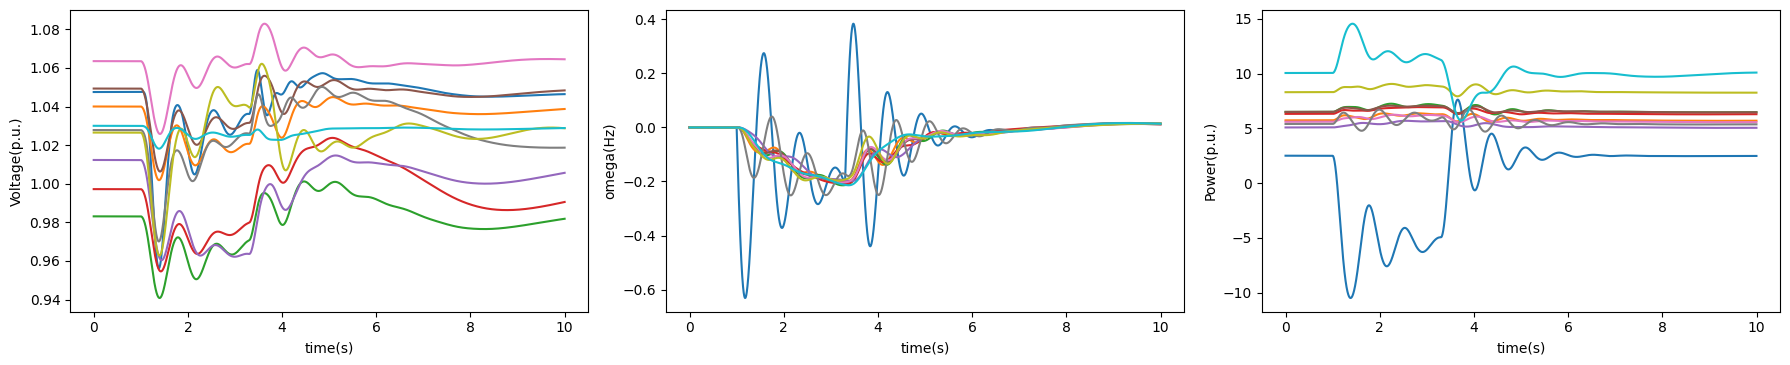

<Figure size 640x480 with 0 Axes>

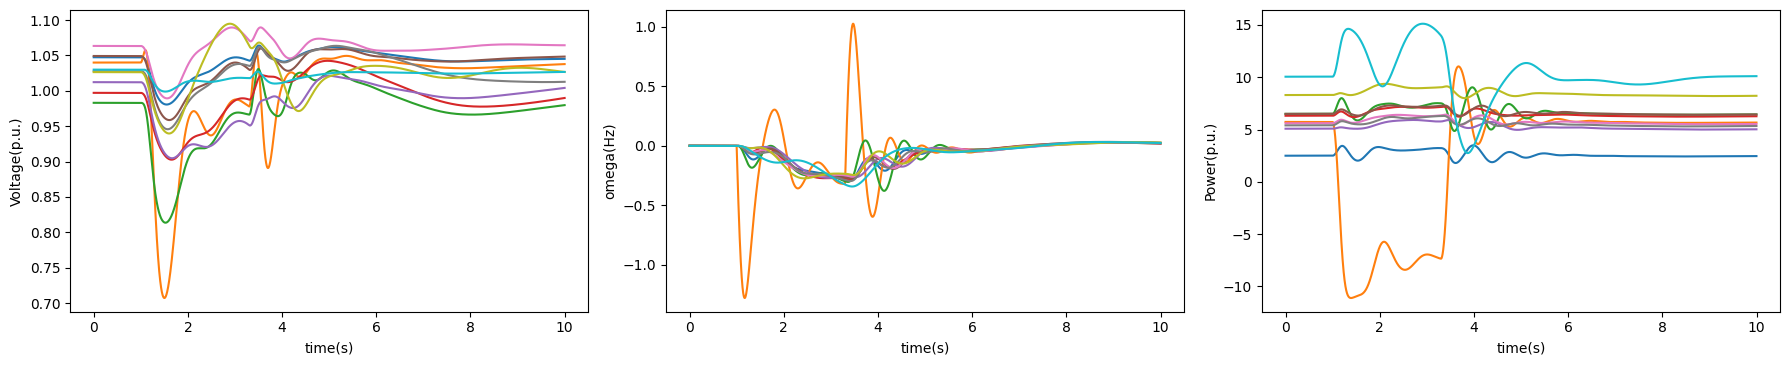

<Figure size 640x480 with 0 Axes>

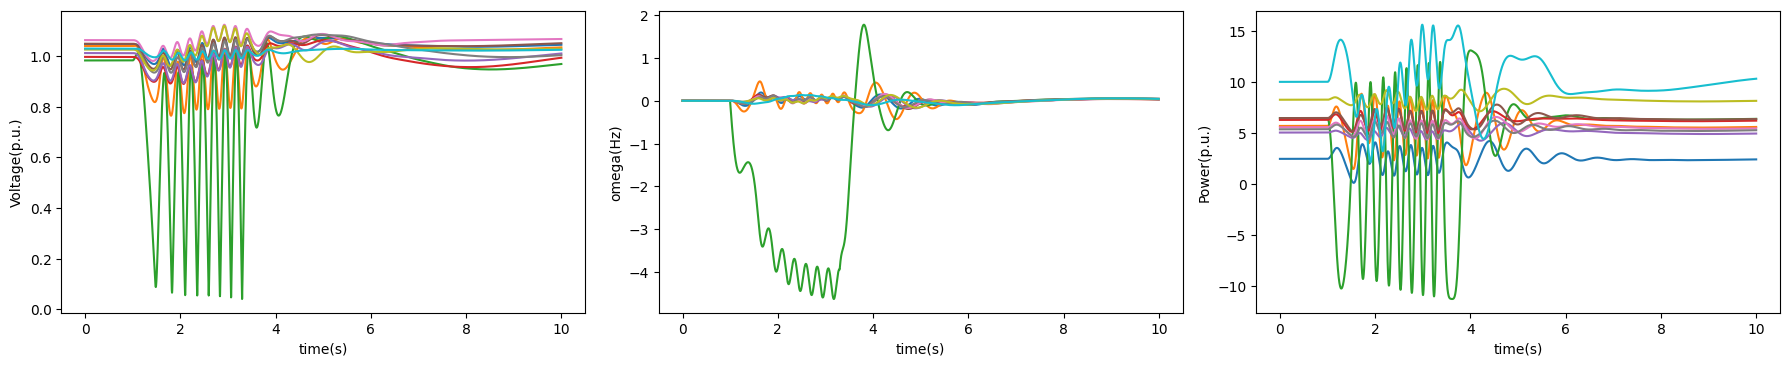

<Figure size 640x480 with 0 Axes>

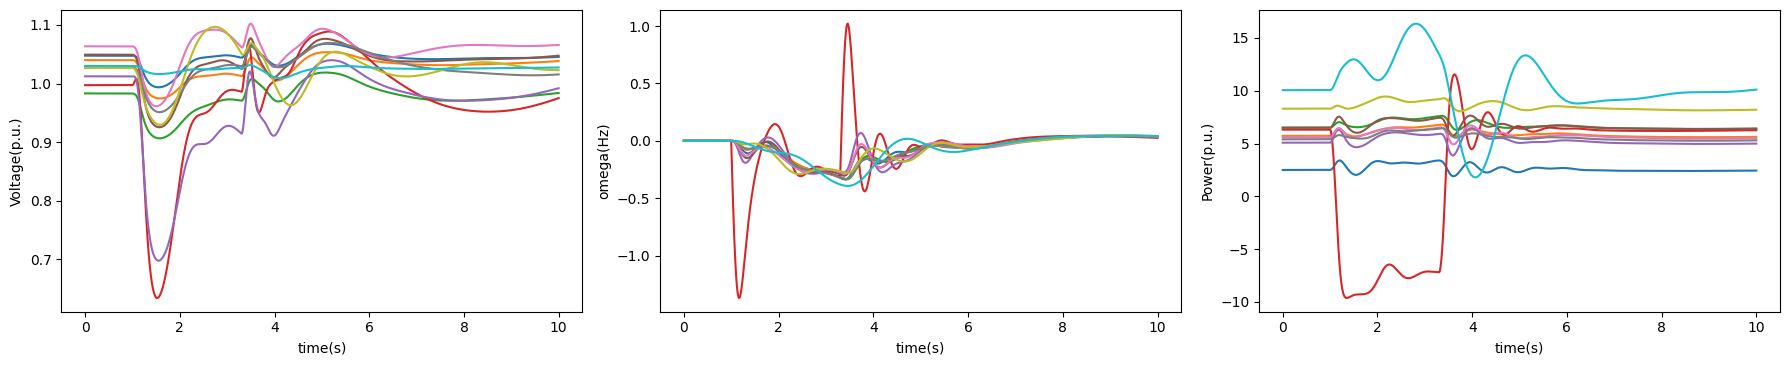

<Figure size 640x480 with 0 Axes>

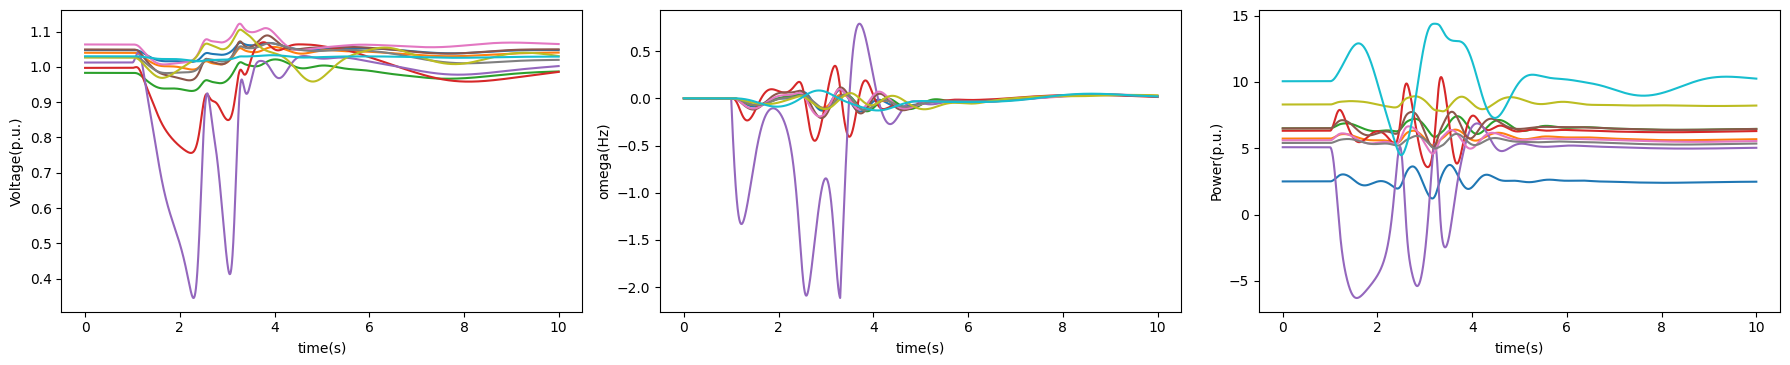

<Figure size 640x480 with 0 Axes>

In [ ]:
# randomly print 10 cases
plt.ion()
# fig = plt.figure(figsize=(5,4), dpi=100)

for test_idx in range(5):
    fig = plt.figure(figsize=(18,4), dpi=100)

    voltage = record_fault_trajectory[test_idx,0,:,:]
    time = 0.001*np.arange(0,np.shape(voltage)[-1])
    plt.subplot(1,3,1)
    plt.plot(time, record_fault_trajectory[test_idx,0,:,:].T)
    plt.xlabel('time(s)')
    plt.ylabel('Voltage(p.u.)')

    # freq = record_fault_trajectory[test_idx,2,:,:]
    plt.subplot(1,3,2)
    plt.plot(time, record_fault_trajectory[test_idx,1,:,:].T)
    plt.xlabel('time(s)')
    plt.ylabel('omega(Hz)')

    plt.subplot(1,3,3)
    plt.plot(time, record_fault_trajectory[test_idx,2,:,:].T)
    plt.xlabel('time(s)')
    plt.ylabel('Power(p.u.)')


    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    plt.pause(0.01)
    plt.clf()




# Environment Setup

## Vulcan Data Extraction

In [ ]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import os


def to_edge_list(edges, data=False):
    """
    :param edges: dict, key: edge name, value: edge attributes
    :param data: bool, whether to include edge attributes
    :return: list of tuple of str (src, tgt) where src/tgt are source/target node names
    """
    if type(edges) is dict:
        if data:
            return {(e["source"], e["target"]): name for name, e in edges.items()}
        else:
            return [(e["source"], e["target"]) for name, e in edges.items()]
    else:
        assert not data
        return [(e["source"], e["target"]) for e in edges]


def plot_nx_graph(G, outpath=None, show=True, edge_info=None, node_info=None, figsize=(12,12)):
    try:
        pos = nx.nx_agraph.graphviz_layout(G, prog="dot", args="")
    except:
        print("graphviz not installed or error. Using spring layout.")
        pos = nx.spring_layout(G)
    pos = {k: (v[0], v[1] + (random.random() - 0.5) * 40) for k, v in pos.items()}
    fig = plt.figure(figsize=figsize)
    if edge_info:
        nx.draw_networkx_edge_labels(G, pos, edge_labels={k: edge_info[k] for k in G.edges}, font_color="red")
    if node_info:
        pos_ = {k: (v[0] + 5, v[1] + 5) for k, v in pos.items()}
        nx.draw_networkx_labels(G, pos_, labels=node_info, font_color="red", font_size=figsize[0], font_weight='bold')
    nx.draw(G, pos, with_labels=True)
    fig.tight_layout()
    if outpath:
        os.makedirs(os.path.dirname(outpath), exist_ok=True)
        plt.savefig(outpath)
    if show:
        plt.show()
    else:
        plt.close()



In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
import networkx as nx

# import utils


def single_phase_lindistflow(circuit_data, node_list=None):
    """
    An implementation of the single-phase LinDistFlow is provided for reference.
    Note that the R, X values are averaged (not summed) across the three phases.
    :param circuit_data: dict, edge list, e.g.
        [
            {
                'element_name': 'line_1',
                'source': 'bus_1',
                'target': 'bus_2',
                'series_impedance': complex,
            },
            ...
        ]
    :param per_unit: bool, if True, convert all quantities to per-unit
        Only p.u. is supported for now.
    :param s_base: float, base power for per-unit conversion
    return: R_matrix, X_matrix, C_matrix, node_list
        R_matrix: np.array, shape=(N, N)
        X_matrix: np.array, shape=(N, N)
        C_matrix: np.array, shape=(N+1, N)
        node_list: list of str, node names
        Usage:
            nodal_voltages = v0 + 2 * (R_matrix @ p_inj[1:] + X_matrix @ q_inj[1:])
            branch_power = np.linalg.inv(C_matrix[1:, :]) @ (p + 1j * q)
    """
    edge_list = utils.to_edge_list(circuit_data)
    graph = nx.DiGraph(edge_list)
    root_node = [n for n in graph.nodes if graph.in_degree(n) == 0]
    assert len(root_node) == 1, f"There should be only one root node: {root_node}"
    assert nx.is_directed_acyclic_graph(graph), "Graph contains a cycle. Only radial networks are supported."
    N = len(graph.nodes) - 1    # Excluding the root node
    assert len(graph.edges) == N, len(graph.edges)
    # Build node_list and assign node id
    node_list = node_list or list(nx.bfs_tree(graph, root_node[0]).nodes())
    assert node_list[0] == root_node[0], f"Root node {node_list[0]} does not match {root_node[0]}"
    node2idx = {node: k for k, node in enumerate(node_list)}
    # Replace node names with integer indicies
    edge_list = [(node2idx[e[0]], node2idx[e[1]]) for e in edge_list]
    graph = nx.DiGraph(edge_list)
    # Check that the node_list is in BFS or DFS order
    for i in range(1, N+1):
        assert not (set(graph.predecessors(i)) - set(range(i))), \
            str('\n'.join([n.split('|')[0] for n in node_list]) + '\n' + str(set(graph.predecessors(i))) + ' ' + str(i))

    # Careful! The graph needs to be in the down orientation.
    # networkx incidence_matrix has the opposite sign convention
    C_matrix = -nx.incidence_matrix(graph, oriented=True, nodelist=list(range(N+1))).toarray()
    ge = list(graph.edges)
    permutation = [ge.index((i, j)) for i, j in edge_list]
    C_matrix = C_matrix[:, permutation]
    C_inv = np.linalg.inv(C_matrix[1:])
    utils.plot_nx_graph(
        graph,
        node_info={i: n.split('|')[0] for i, n in enumerate(node_list)},
        outpath='temp/network.png',
        edge_info={e: circuit_data[i]['series_impedance'] for i, e in enumerate(edge_list)},
    )

    resistances, reactances = np.zeros(N), np.zeros(N)
    for edge in circuit_data:
        e = edge_list.index((node2idx[edge['source']], node2idx[edge['target']]))
        resistances[e] = edge['series_impedance'].real
        reactances[e] = edge['series_impedance'].imag
    R_matrix = C_inv.T @ np.diag(resistances) @ C_inv
    X_matrix = C_inv.T @ np.diag(reactances) @ C_inv
    return R_matrix, X_matrix, C_matrix, node_list, edge_list


def load_compute_power(file, t0, t1, keys):
    """
    :param file: str, path to the csv file
    :param t0: str, start time in 'YYYY/MM/DD HH:MM:SS.sss'
    :param t1: str, end time in 'YYYY/MM/DD HH:MM:SS.sss'
    :param keys: dict, e.g. {'t': 'timestamp', 'p': 'power.draw [W]'}
    :return: dict with keys 't' (float seconds) and 'power_factor' (per-unit power)
    """
    # Read CSV with timestamp parsing
    df = pd.read_csv(file, parse_dates=[keys['t']])
    # Convert t0, t1 to datetime
    t0_dt = pd.to_datetime(t0)
    t1_dt = pd.to_datetime(t1)
    # Filter by time range
    mask = (df[keys['t']] >= t0_dt) & (df[keys['t']] <= t1_dt)
    df = df.loc[mask, [keys['t'], keys['p']]].copy()
    # Rename columns to standardized names
    df.rename(columns={keys['t']: 't', keys['p']: 'power'}, inplace=True)
    # Compute per-unit power
    max_p = df['power'].max()
    df['power_factor'] = df['power'] / max_p
    # Reset time to start from zero (in seconds)
    df['t'] = (df['t'] - df['t'].iloc[0]).dt.total_seconds()
    # Return dictionary of arrays
    return {'t': df['t'].to_numpy(), 'compute_power_factor': df['power_factor'].to_numpy()}


def load_v0(file, keys, dt):
    """
    :param file: str, path to the csv file
    :param t0: str, start time in 'YYYY/MM/DD HH:MM:SS.sss'
    :param t1: str, end time in 'YYYY/MM/DD HH:MM:SS.sss'
    :param keys: dict, e.g. {'t': 'timestamp', 'v0': 'voltage [V]'}
    :return: dict with keys 't' (float seconds) and 'v0' (voltage)
    """
    # Read CSV with timestamp parsing
    if file.endswith('.csv'):
        df = pd.read_csv(file, parse_dates=[keys['t']])
    elif file.endswith('.mat'):
        df = sp.io.loadmat(file)
        df = pd.DataFrame({'v0': df[keys['v0']][3, 0, 3]})

    # Create time column
    df['t'] = dt * np.arange(0, len(df['v0']))

    # Return dictionary of arrays
    return {'t': df['t'].to_numpy(), 'v0': df['v0'].to_numpy()}


def align_data(data, dt):
    """
    Align multiple datasets by a common time base using linear interpolation.
    :param data: dict of named dicts, each with keys 't' and one other data array
    :param resample_interval: float, time step in seconds for interpolation
    :return: None (data is modified in place)
    """
    aligned_data = {}
    # Determine intersection of time ranges
    starts = []
    ends = []
    for entry in data.values():
        t_arr = np.array(entry['t'], dtype=float)
        starts.append(t_arr[0])
        ends.append(t_arr[-1])
    t_start = max(starts)
    t_end = min(ends)
    # Create new common time vector
    aligned_data['t'] = np.arange(t_start, t_end, dt)
    # Interpolate each series onto new time base
    for name, entry in data.items():
        # Identify data field (exclude 't')
        for k, v in entry.items():
            if k == 't':
                continue
            # Linear interpolation
            aligned_data[k] = np.interp(aligned_data['t'], entry['t'], v)
    return aligned_data


# if __name__ == "__main__":
#     R_matrix, X_matrix, C_matrix, node_list, edge_list = single_phase_lindistflow(vulcan_circuit_data)
#     print("R_matrix:", R_matrix.shape)
#     print("X_matrix:", X_matrix.shape)
#     print("C_matrix:", C_matrix.shape)
#     print("Edge list:", len(edge_list))
#     print("Node list:", len(node_list))

#     file = 'data/compute-power-readings/llama_b16_i512_o128_tp4/nvidiasmi_monitor.csv'
#     t0, t1 = '2023/10/18 17:41:36.473', '2023/10/18 17:42:22.703'
#     keys = {'t': 'timestamp', 'p': 'power.draw [W]'}
#     compute_power = load_compute_power(file, t0, t1, keys)

#     file = 'data/record_trajectory_LossGen.mat'
#     keys = {'v0': 'record_trajectory'}
#     dt = 1e-2  # Resample interval in seconds
#     v0 = load_v0(file, keys, dt)

#     data = {'compute_power': compute_power, 'v0': v0}
#     resample_dt = 1e-2
#     aligned_data = align_data(data, resample_dt)
#     for k, v in aligned_data.items():
#         print(f"{k}: {v.shape}")

In [ ]:
def load_compute_power_ms(file, t0, t1, keys):
    """
    :param file: str, path to the csv file
    :param t0: str, start time in 'YYYY/MM/DD HH:MM:SS.sss'
    :param t1: str, end time in 'YYYY/MM/DD HH:MM:SS.sss'
    :param keys: dict, e.g. {'t': 'timestamp', 'p': 'power.draw [W]'}
    :return: dict with keys 't' (float seconds) and 'power_factor' (per-unit power)
    """
    # Read CSV with timestamp parsing
    df = pd.read_csv(file)

    t0 = 35
    t1 = 50

    # Filter by numeric time range
    mask = (df['time_s'] >= t0) & (df['time_s'] <= t1)
    df = df.loc[mask, ['time_s', 'gpu_power_norm']].copy()

    if df.empty:
        result = {'t': np.array([]), 'compute_power_factor': np.array([])}
    else:
        # Rename columns
        df.rename(columns={'time_s': 't', 'gpu_power_norm': 'power'}, inplace=True)

        # Reset time to start from zero
        df['t'] = df['t'] - df['t'].iloc[0]

        # Compute per-unit power
        max_p = df['power'].max()
        df['power_factor'] = df['power'] / max_p if max_p != 0 else 0

        return {
            't': df['t'].to_numpy(),
            'compute_power_factor': df['power_factor'].to_numpy()
        }

In [ ]:
import pandas as pd
import numpy as np

file = 'data/compute-power-readings/gpu_compute_power_Choukse_power_stabilization.csv'
df = pd.read_csv(file)

t0 = 35
t1 = 45

# Filter by numeric time range
mask = (df['time_s'] >= t0) & (df['time_s'] <= t1)
df = df.loc[mask, ['time_s', 'gpu_power_norm']].copy()

if df.empty:
    result = {'t': np.array([]), 'compute_power_factor': np.array([])}
else:
    # Rename columns
    df.rename(columns={'time_s': 't', 'gpu_power_norm': 'power'}, inplace=True)

    # Reset time to start from zero
    df['t'] = df['t'] - df['t'].iloc[0]

    # Compute per-unit power
    max_p = df['power'].max()
    df['power_factor'] = df['power'] / max_p if max_p != 0 else 0

    result = {
        't': df['t'].to_numpy(),
        'compute_power_factor': df['power_factor'].to_numpy()
    }

# result


Text(0, 0.5, ' P')

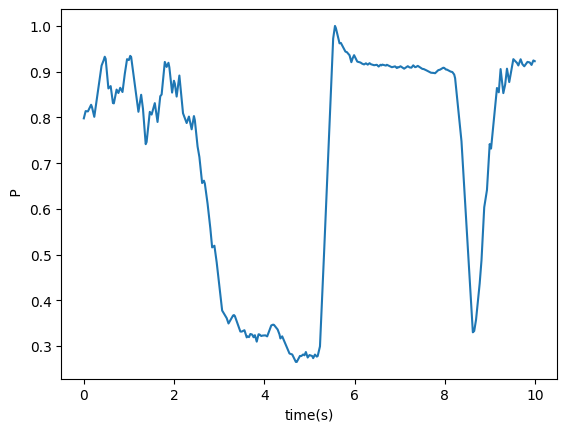

In [ ]:
plt.plot(df['t'],df['power_factor'])
plt.xlabel('time(s)')
plt.ylabel(' P')

In [ ]:

vulcan_circuit_data = [
    {
        'element_name': 'line_grid_utility_a_pri',
        'source': 'interconnection_a',
        'target': 'utility_a_pri',
        'series_impedance': 0.000571+0.006432j,           # 345kV line, 10 mile, in p.u.
    },
    {
        'element_name': 'tr_utility_a_mv',
        'source': 'utility_a_pri',
        'target': 'mv_distribution_bus',
        'series_impedance': 9.14e-06+0.000163975j,      # 400MVA rating, in p.u.
    },
    {
        'element_name': 'tr_mv_bat_1',
        'source': 'mv_distribution_bus',
        'target': 'batt_1_sec',
        'series_impedance': 5e-05+0.001663j,           # 100MVA rating
    },
    {
        'element_name': 'tr_mv_bat_2',
        'source': 'mv_distribution_bus',
        'target': 'batt_2_sec',
        'series_impedance': 5e-05+0.001663j,        # 20MVA rating
    },
    {
        'element_name': 'tr_mv_cooling_1',
        'source': 'mv_distribution_bus',
        'target': 'cooling_1_sec',
        'series_impedance': 6.235e-05+0.00207875j,        # 20MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_1',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_1_sec',
        'series_impedance': 0.0001995+0.006652j,        # 25MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_2',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_2_sec',
        'series_impedance': 0.0001995+0.006652j,        # 25MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_3',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_3_sec',
        'series_impedance': 0.0001995+0.006652j,        # 25MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_4',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_4_sec',
        'series_impedance': 0.0001995+0.006652j,        # 25MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_5',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_5_sec',
        'series_impedance': 0.0001995+0.006652j,        # 25MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_6',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_6_sec',
        'series_impedance': 0.0001995+0.006652j,        # 25MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_7',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_7_sec',
        'series_impedance': 0.0001995+0.006652j,        # 25MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_8',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_8_sec',
        'series_impedance': 0.0001995+0.006652j,        # 25MVA rating
    },
]

vulcan_bus_data = {
    'interconnection_a': {'qmin': 0, 'qmax': 0, 'type': 'grid'},
    'utility_a_pri': {'qmin': 0, 'qmax': 0, 'type': 'internal'},
    'mv_distribution_bus': {'qmin': 0, 'qmax': 0, 'type': 'internal'},
    'batt_1_sec': {'qmin': -100, 'qmax': 100, 'p_rating': 100, 'type': 'battery'},
    'batt_2_sec': {'qmin': -100, 'qmax': 100, 'p_rating': 100, 'type': 'battery'},
    'cooling_1_sec': {'qmin': 0, 'qmax': 0, 'p_rating': 80, 'type': 'cooling'},
    'datacenter_1_sec': {'qmin': -4, 'qmax': 4, 'p_rating': 5, 'type': 'compute'},
    'datacenter_2_sec': {'qmin': -4, 'qmax': 4, 'p_rating': 5, 'type': 'compute'},
    'datacenter_3_sec': {'qmin': -4, 'qmax': 4, 'p_rating': 5, 'type': 'compute'},
    'datacenter_4_sec': {'qmin': -4, 'qmax': 4, 'p_rating': 5, 'type': 'compute'},
    'datacenter_5_sec': {'qmin': -4, 'qmax': 4, 'p_rating': 5, 'type': 'compute'},
    'datacenter_6_sec': {'qmin': -4, 'qmax': 4, 'p_rating': 5, 'type': 'compute'},
    'datacenter_7_sec': {'qmin': -4, 'qmax': 4, 'p_rating': 5, 'type': 'compute'},
    'datacenter_8_sec': {'qmin': -4, 'qmax': 4, 'p_rating': 5, 'type': 'compute'},
}

In [ ]:

# def decentralized_K(X):
#     # First, find the K matrix.
#     N = X.shape[0]
#     beta = np.ones(N)

#     # Variables
#     k = cp.Variable(N)

#     # Objective: maximize sum(beta_i * log(k_i))
#     objective = cp.Maximize(cp.sum(cp.multiply(beta, cp.log(k))))

#     # Constraints: 0 < k_i < 2^(X-1)
#     constraints = [
#         k >= 1e-6,  # strictly positive (use small epsilon)
#         cp.diag(k) <= 2 * np.linalg.inv(X)
#     ]

#     # Problem definition
#     prob = cp.Problem(objective, constraints)
#     prob.solve()

#     print("Optimal k:", k.value)
#     return k.value


# def controller_decentralized(v, K, q_t):
#     """
#     Decentralized safe reinforcement learning for inverter-based voltage control
#     """
#     q = q_t - K * v
#     return q


def controller_centralized_optimization(v, X, q_min, q_max, ctrl_cost=1e-9, v_cost=1,):
    # Compute the optimal control action
    q = cp.Variable(len(v))
    objective = cp.Minimize(
        # ctrl_cost * cp.sum_squares(q) +
        cp.quad_form(v + 2 * X @ q - 1, np.diag(np.ones(len(v)) * v_cost))
    )
    constraints = [
        q >= q_min,
        q <= q_max
    ]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    assert prob.status == 'optimal'
    # todo: add active power support
    return 0, q.value


def run_simulation(CENTRALIZED__CTRL_DELAY_STEPS=2):
    """
    Run the simulation with either decentralized or centralized control.
    :param v: voltage vector
    :param R: resistance matrix
    :param X: reactance matrix
    :param K: control gain
    :param centralized: bool, whether to use centralized control
    :return: None
    """
    # Load data
    R_matrix, X_matrix, C_matrix, node_list, edge_list = \
        load_data.single_phase_lindistflow(vulcan_circuit_data)
    N = len(node_list) - 1

    # file = 'data/compute-power-readings/llama_b16_i512_o128_tp4/nvidiasmi_monitor.csv'
    file = 'data/compute-power-readings/gpu_compute_power_Choukse_power_stabilization.csv'
    t0, t1 = '2023/10/18 17:41:36.473', '2023/10/18 17:42:22.703'
    keys = {'t': 'timestamp', 'p': 'power.draw [W]'}
    compute_power = load_data.load_compute_power_ms(file, t0, t1, keys)

    file = 'data/record_trajectory_LossGen_t0.001.mat'
    keys = {'v0': 'record_trajectory'}
    dt = 1e-3  # Resample interval in seconds
    v0 = load_data.load_v0(file, keys, dt)

    data = {'compute_power': compute_power, 'v0': v0}
    resample_dt = 1e-3
    aligned_data = load_data.align_data(data, resample_dt)
    T = len(aligned_data['t'])
    print(f"Loaded data with {C_matrix.shape} nodes and edges and {T} time steps.")

    # Simulation parameters
    q_min, q_max = np.zeros(N), np.zeros(N)
    p_inj = np.zeros((T, N))


    for n, node in enumerate(node_list[1:]):
        q_min[n] = vulcan_bus_data[node]['qmin']
        q_max[n] = vulcan_bus_data[node]['qmax']
        if vulcan_bus_data[node]['type'] == 'compute':
            p_inj[:, n] = -vulcan_bus_data[node]['p_rating'] * aligned_data['compute_power_factor']
        elif vulcan_bus_data[node]['type'] == 'cooling':
            p_inj[:, n] = -vulcan_bus_data[node]['p_rating'] * np.mean(aligned_data['compute_power_factor'])


    v_solution = {
        't': aligned_data['t'],
        'v0': aligned_data['v0'],
        'compute_power_factor': aligned_data['compute_power_factor'],
        'no_control': np.zeros((T, N)),
        'centralized': np.zeros((T, N)),
        'decentralized': np.zeros((T, N)),
    }


    p_ctrl_cen, q_ctrl_cen = np.zeros((T + CENTRALIZED__CTRL_DELAY_STEPS, N)), np.zeros((T + CENTRALIZED__CTRL_DELAY_STEPS, N))
    for t in range(T):
        p = p_inj[t]
        v0 = aligned_data['v0'][t]
        # Compute voltage without control
        v = v0 + 2 * R_matrix @ p
        v_solution['no_control'][t, :] = v
        # Apply centralized control
        p_t, q_t = controller_centralized_optimization(v, X_matrix, q_min, q_max)
        p_ctrl_cen[t + CENTRALIZED__CTRL_DELAY_STEPS] = p_t
        q_ctrl_cen[t + CENTRALIZED__CTRL_DELAY_STEPS] = q_t
        v = v0 + 2 * (R_matrix @ (p + p_ctrl_cen[t]) + X_matrix @ q_ctrl_cen[t])
        v_solution['centralized'][t, :] = v
        # # Apply decentralized control
        # q = controller_decentralized(v, K, q_t)
        # v = v0 + 2 * (R_matrix @ p + X_matrix @ q)
        # v_solution['decentralized'][t, :] = v
    v_solution['p_ctrl_centralized'] = p_ctrl_cen[:T]
    v_solution['q_ctrl_centralized'] = q_ctrl_cen[:T]
    return v_solution


def plot_simulation(t, V, P, Q, title, nodes_to_plot=None, out_path='temp', ext='png', figsize=(12, 3)):
    N = V.shape[1]
    if not nodes_to_plot:
        nodes_to_plot = list(range(min(10, N)))

    fig, axes = plt.subplots(1, 3, figsize=figsize, constrained_layout=False)
    fig.suptitle(title)

    # Voltages
    for i in nodes_to_plot:
        axes[0].plot(t, V[:, i], label=f"Node {i+1}")
    axes[0].set_xlabel("time(s)")
    axes[0].set_ylabel("V (p.u.)")
    axes[0].grid(True, alpha=0.3)

    # Action P
    for i in nodes_to_plot:
        axes[1].plot(t, P[:, i], label=f"Node {i+1}")
    axes[1].set_xlabel("time(s)")
    axes[1].set_ylabel("Action P")
    axes[1].grid(True, alpha=0.3)

    # Action Q
    for i in nodes_to_plot:
        axes[2].plot(t, Q[:, i], label=f"Node {i+1}")
    axes[2].set_xlabel("time(s)")
    axes[2].set_ylabel("Action Q")
    axes[2].grid(True, alpha=0.3)

    plt.legend()
    plt.tight_layout()
    os.makedirs(out_path, exist_ok=True)
    plt.savefig(os.path.join(out_path, f"{title}.{ext}"))



In [ ]:
import utils


graphviz not installed or error. Using spring layout.


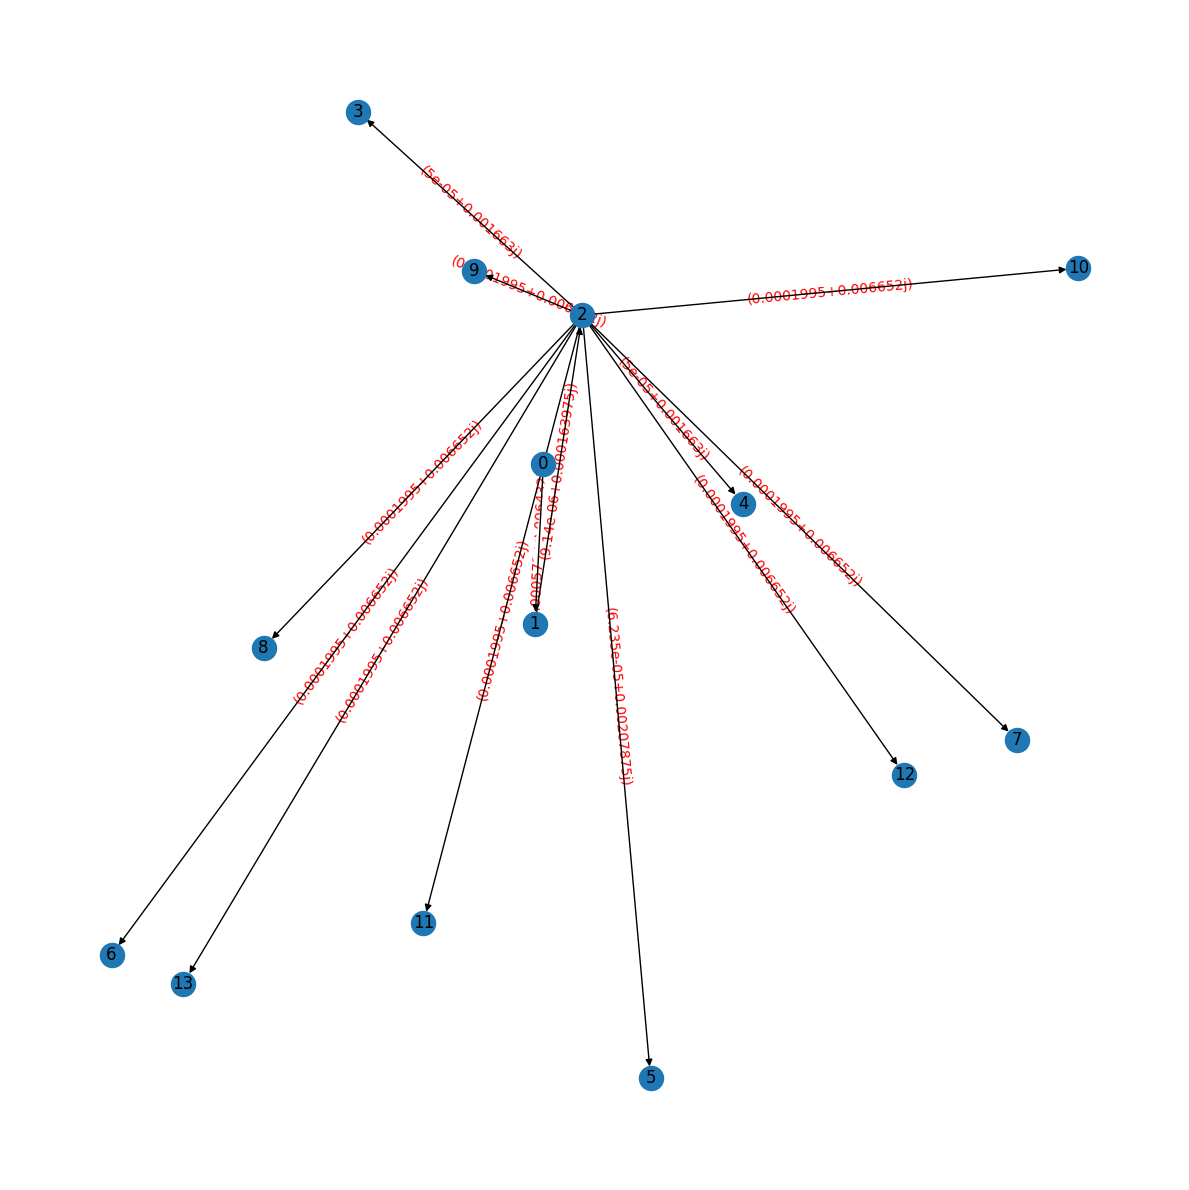

Loaded data with (14, 13) nodes and edges and 9999 time steps.


In [ ]:
    """
    Run the simulation with either decentralized or centralized control.
    :param v: voltage vector
    :param R: resistance matrix
    :param X: reactance matrix
    :param K: control gain
    :param centralized: bool, whether to use centralized control
    :return: None
    """
    CENTRALIZED__CTRL_DELAY_STEPS=2
    # Load data
    R_matrix, X_matrix, C_matrix, node_list, edge_list = \
        single_phase_lindistflow(vulcan_circuit_data)
    N = len(node_list) - 1

    # file = 'data/compute-power-readings/llama_b16_i512_o128_tp4/nvidiasmi_monitor.csv'
    file = 'data/compute-power-readings/gpu_compute_power_Choukse_power_stabilization.csv'

    t0, t1 = '2023/10/18 17:41:36.473', '2023/10/18 17:42:22.703'
    keys = {'t': 'timestamp', 'p': 'power.draw [W]'}
    compute_power = load_compute_power_ms(file, t0, t1, keys)

    file = 'data/record_trajectory_LossGen_t0.001.mat'
    keys = {'v0': 'record_trajectory'}
    dt = 1e-3  # Resample interval in seconds
    v0 = load_v0(file, keys, dt)

    data = {'compute_power': compute_power, 'v0': v0}
    resample_dt = 1e-3
    aligned_data = align_data(data, resample_dt)
    T = len(aligned_data['t'])
    print(f"Loaded data with {C_matrix.shape} nodes and edges and {T} time steps.")

    # Simulation parameters
    q_min, q_max = np.zeros(N), np.zeros(N)
    p_inj = np.zeros((T, N))
    for n, node in enumerate(node_list[1:]):
        q_min[n] = vulcan_bus_data[node]['qmin']
        q_max[n] = vulcan_bus_data[node]['qmax']
        if vulcan_bus_data[node]['type'] == 'compute':
            p_inj[:, n] = -vulcan_bus_data[node]['p_rating'] * aligned_data['compute_power_factor']
        elif vulcan_bus_data[node]['type'] == 'cooling':
            p_inj[:, n] = -vulcan_bus_data[node]['p_rating'] * np.mean(aligned_data['compute_power_factor'])
    v0_move = 0
    p_inj = 2*p_inj

    Q_ref = -1*(LA.inv(X_matrix))@R_matrix@np.mean(p_inj[0:100],axis=0)

    v_solution = {
        't': aligned_data['t'],
        'v0': aligned_data['v0'],
        'compute_power_factor': aligned_data['compute_power_factor'],
        'no_control': np.zeros((T-v0_move, N)),
        'centralized': np.zeros((T-v0_move, N)),
        'decentralized': np.zeros((T-v0_move, N)),
    }
    p_ctrl_cen, q_ctrl_cen = np.zeros((T + CENTRALIZED__CTRL_DELAY_STEPS- v0_move, N)), np.zeros((T + CENTRALIZED__CTRL_DELAY_STEPS- v0_move, N))
    for t in range(T- v0_move):
        p = p_inj[t]
        v0 = aligned_data['v0'][v0_move+t]
        # Compute voltage without control
        v = v0 + 2 * R_matrix @ p + 2 * X_matrix @ Q_ref
        v_solution['no_control'][t, :] = v
        # Apply centralized control
        p_t, q_t = controller_centralized_optimization(v, X_matrix, q_min, q_max)
        p_ctrl_cen[t + CENTRALIZED__CTRL_DELAY_STEPS] = p_t
        q_ctrl_cen[t + CENTRALIZED__CTRL_DELAY_STEPS] = q_t
        v = v0 + 2 * (R_matrix @ (p + p_ctrl_cen[t]) + X_matrix @ (Q_ref+q_ctrl_cen[t]))
        v_solution['centralized'][t, :] = v
        # # Apply decentralized control
        # q = controller_decentralized(v, K, q_t)
        # v = v0 + 2 * (R_matrix @ p + X_matrix @ q)
        # v_solution['decentralized'][t, :] = v
    v_solution['p_ctrl_centralized'] = p_ctrl_cen[:T- v0_move]
    v_solution['q_ctrl_centralized'] = q_ctrl_cen[:T- v0_move]
    # return v_solution


In [ ]:
aligned_data['v0'][T- v0_move:]

In [ ]:
plt.plot(aligned_data['v0'])

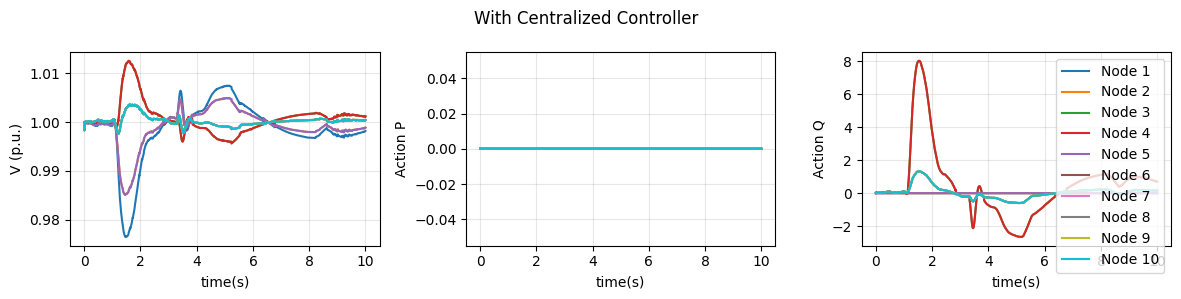

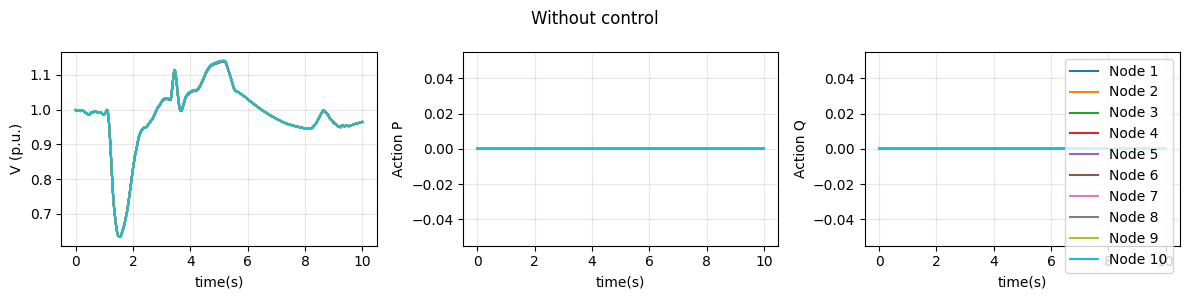

In [ ]:
plot_simulation(v_solution['t'][:T- v0_move], v_solution['centralized'][:T- v0_move], v_solution['p_ctrl_centralized'][:T- v0_move], v_solution['q_ctrl_centralized'][:T- v0_move], "With Centralized Controller")
plt.savefig('/content/drive/MyDrive/Colab Notebooks/250805 data center/figure/exp_Centralized_MS_F4.png', bbox_inches='tight', dpi=600)

plot_simulation(v_solution['t'][:T- v0_move], v_solution['no_control'][:T- v0_move], np.zeros_like(v_solution['no_control'][:T- v0_move]), np.zeros_like(v_solution['no_control'][:T- v0_move]), "Without control")

In [ ]:
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/250805 data center/figure/Decentralized.png', bbox_inches='tight', dpi=600)


## initialize the variables and system matrices





In [ ]:
# Frequency Control Porblem Environment
class Voltage(gym.Env):
    def  __init__(self, Matrix_X,Matrix_R, max_action,dim_action,Penalty_action):
        self.param_gamma=1
        self.Matrix_X = Matrix_X.astype(np.float32)
        self.Matrix_R = Matrix_R.astype(np.float32)
        self.inv_Matrix_X = LA.inv(Matrix_X).astype(np.float32)
        self.lambda_max = np.max(LA.eigvals(Matrix_X))
        self.max_action = max_action.astype(np.float32)
        self.dim_action=dim_action
        self.delta_t = 1
        self.state=[]
        self.Penalty_action=Penalty_action


    def step(self, action):
        # action=K.dot(self.Multiply_V_ref-K.dot(prev_output, self.select_V),tf.linalg.diag(Vector_A))
        # integrate the state transition dynamics

        self.state=(self.state-action@(self.Matrix_X.T)).copy()
        # loss = self.param_gamma*np.sum(abs(self.V_ref.T-self.state@self.select_V))
        return self.state

    def step_varyingP(self, action, Pt):


        self.state=(self.state-action@(self.Matrix_X.T)+Pt@(self.Matrix_R.T)).copy()
        return self.state

    def set_state(self, state_input):
        self.state=state_input


    def reset(self):
        self.state = np.random.uniform(-1,1,(1,self.dim_action)).astype(np.float32)

        return self.state



In [ ]:
# Simulation data load from IEEE 39-bus system
# data = loadmat('/content/drive/MyDrive/Colab Notebooks/voltage control/TestCase33.mat')
# filename='TestCase'
Matrix_R=2*R_matrix

Matrix_X=2*X_matrix
dim_action=np.shape(Matrix_X)[0]
V_ref=np.ones((dim_action,1))

# Q_ref=np.array([[ 3.75633894e-06],
#        [ 3.89703169e-06],
#        [-3.50238264e-01],
#        [-1.17711040e-01],
#        [ 7.29899859e-06],
#        [ 3.01891400e-01],
#        [ 3.01891400e-01]])

P_ref=np.mean(p_inj[0:100],axis=0)

X = Matrix_X

In [ ]:
P_ref

array([   0.        ,    0.        ,    0.        ,    0.        ,
       -113.95652572,   -8.10348735,   -8.10348735,   -8.10348735,
         -8.10348735,   -8.10348735,   -8.10348735,   -8.10348735,
         -8.10348735])

In [ ]:


Penalty_action=0.1
max_action= q_max
# np.random.uniform(low=0.01, high=0.05, size=(1,dim_action))
# V_ref=Matrix_R@P_ref+Matrix_X@Q_ref+np.ones((dim_action,1))
Q_ref = -1*(LA.inv(Matrix_X))@Matrix_R@P_ref
env = Voltage(Matrix_X,Matrix_R, max_action,dim_action,Penalty_action)


In [ ]:
q_max

array([  0.,   0., 100., 100.,   0.,   4.,   4.,   4.,   4.,   4.,   4.,
         4.,   4.])

In [ ]:
Q_ref

array([ 5.90608470e+00,  4.60321760e+00, -1.09184521e-15, -1.09184521e-15,
        3.41801053e+00,  2.43031528e-01,  2.43031528e-01,  2.43031528e-01,
        2.43031528e-01,  2.43031528e-01,  2.43031528e-01,  2.43031528e-01,
        2.43031528e-01])

In [ ]:
lambda_max = np.max(LA.eigvals(Matrix_X))
print(LA.eigvals(Matrix_X))
2/lambda_max

[1.80096015e-01 6.69497008e-03 1.43672092e-04 1.16085058e-03
 3.85939226e-03 1.33040000e-02 3.32600000e-03 1.33040000e-02
 1.33040000e-02 1.33040000e-02 1.33040000e-02 1.33040000e-02
 1.33040000e-02]


np.float64(11.10518742007339)

# CVX

## Bounds for linear coefficients

In [ ]:
Matrix_X_inv=np.linalg.inv(Matrix_X)

In [ ]:
# weight_bound = np.ones(dim_action)

# K_bound=cp.Variable(dim_action,nonneg =True)
# objective = cp.Maximize(cp.sum(weight_bound*cp.log(K_bound)))
# diag_K_bound = cp.diag(K_bound)
# constraints = [(diag_K_bound -2*Matrix_X_inv)<<0,diag_K_bound>>0]

# prob = cp.Problem(objective, constraints)
# result = prob.solve()
# print('status',prob.status)
# K_bound=np.array(K_bound.value)

In [ ]:
Matrix_X_inv=np.linalg.inv(Matrix_X)
Matrix_R_inv=np.linalg.inv(Matrix_R)

In [ ]:
ratio_q = 0.5
K_bound=cp.Variable(dim_action,nonneg =True)
objective = cp.Maximize(cp.sum(cp.log(K_bound)))
diag_K_bound = cp.diag(K_bound)
constraints = [(diag_K_bound -ratio_q*2*Matrix_X_inv)<<0,diag_K_bound>>0]

prob = cp.Problem(objective, constraints)
result = prob.solve()
print('status',prob.status)
K_bound_q=np.array(K_bound.value)

ratio_p = 1 - ratio_q
K_bound=cp.Variable(dim_action,nonneg =True)
objective = cp.Maximize(cp.sum(cp.log(K_bound)))
diag_K_bound = cp.diag(K_bound)
constraints = [(diag_K_bound -ratio_p*2*Matrix_R_inv)<<0,diag_K_bound>>0]

prob = cp.Problem(objective, constraints)
result = prob.solve()
print('status',prob.status)
K_bound_p=np.array(K_bound.value)

print('K_bound_p', K_bound_p)
print('K_bound_q', K_bound_q)

status optimal
status optimal
K_bound_p [69.48057394 67.47710163 66.58160031 66.58160032 66.36478804 64.07117701
 64.07117698 64.07117701 64.071177   64.071177   64.07117703 64.07117702
 64.07117701]
K_bound_q [6.41753262 6.12753833 5.88982827 5.88982827 5.83391239 5.29469227
 5.29469227 5.29469227 5.29469227 5.29469227 5.29469227 5.29469227
 5.29469227]


## LQR results for comparison

In [ ]:
from scipy import linalg


In [ ]:
def dlqr(A,B,Q,R):
    """Solve the discrete time lqr controller.


    x[k+1] = A x[k] + B u[k]

    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]

    cite: http://www.kostasalexis.com/lqr-control.html
    """
    #ref Bertsekas, p.151

    #first, try to solve the ricatti equation
    X_ = np.matrix(linalg.solve_discrete_are(A, B, Q, R))

    #compute the LQR gain
    K_ = -np.matrix(linalg.inv(B.T@X_@B+R)*(B.T@X_@A))

    eigVals, eigVecs = linalg.eig(A+B@K_)

    return -K_, X_, eigVals

In [ ]:
A_m = np.eye(dim_action)
B_m = np.hstack((Matrix_X, Matrix_R))
Q = np.eye(dim_action)
R = 1*np.eye(dim_action*2)
K_, X_, eigVals = dlqr(A_m,B_m,Q,R)

In [ ]:
np.diag(K_)

array([0.98356325, 0.98856614, 0.99157896, 0.99157896, 0.99116984,
       0.98664946, 0.98664946, 0.98664946, 0.98664946, 0.98664946,
       0.98664946, 0.98664946, 0.98664946])

# Init Simulation

In [ ]:
#linear droop control
def Action_linear(state,linear_coff):
    action_nonconstrain = state*linear_coff
    action=action_nonconstrain
    # env.max_action-tf.nn.relu(env.max_action-action_nonconstrain)+tf.nn.relu(-env.max_action-action_nonconstrain)
    return action

# def Action_constraints(action_nonconstrain, action_max, action_min):
#     action=
#     # env.max_action-K.relu(env.max_action-action_nonconstrain)+K.relu(-env.max_action-action_nonconstrain)
#     return action
# def Action_constraints(action_nonconstrain):
#     action=env.max_action-K.relu(env.max_action-action_nonconstrain)+K.relu(-env.max_action-action_nonconstrain)
#     return action

In [ ]:

linear_coffp= np.random.uniform(low=1, high=1, size=(1,dim_action))*0.2
linear_coffq= np.random.uniform(low=1, high=1, size=(1,dim_action))*0.2
# linear_coffp= K_[0:dim_action].reshape((1,-1))
# linear_coffq= K_[dim_action:].reshape((1,-1))
action_units=dim_action

In [ ]:
p_inj_diff = np.diff(p_inj, axis=0)

Text(0, 0.5, ' P')

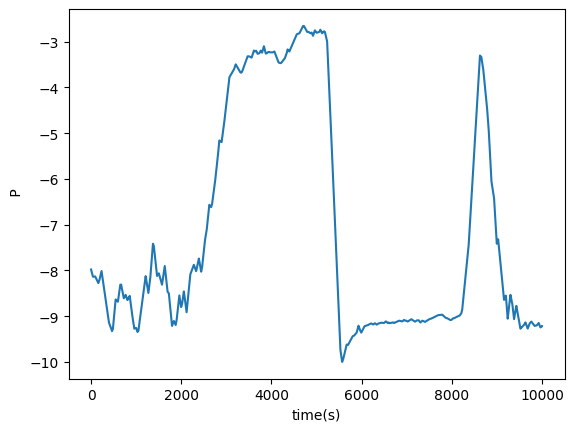

In [ ]:
TimeRecord=np.arange(0,p_inj.shape[0])

plt.plot(TimeRecord,p_inj[:,5])
plt.xlabel('time(s)')
plt.ylabel(' P')

In [ ]:
p_inj.shape

(9999, 13)

In [ ]:
# TimeRecord=np.arange(0,p_inj_diff.shape[0])

# plt.plot(TimeRecord,p_inj_diff)
# plt.xlabel('time(s)')
# plt.ylabel(' P')

### With V0 after fault, time-varying p

s [0.99833549 0.99835366 0.99835366 0.99835366 0.99835366 0.99840325
 0.99840325 0.99840325 0.99840325 0.99840325 0.99840325 0.99840325
 0.99840325]


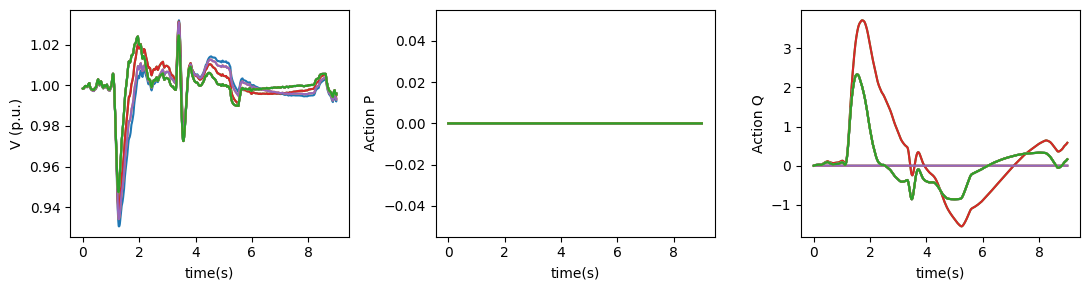

In [ ]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[]
Q_init_ratio = 0.7
P_init_ratio = 0.7
delta_t = 0.001
Q = 1*Q_ref
# 0*(Q_ref*np.random.uniform(1-Q_init_ratio ,1+Q_init_ratio ,(dim_action, 1))).T
# P = (P_ref*np.random.uniform(1-P_init_ratio ,1+P_init_ratio ,(dim_action, 1))).T
P = p_inj[0]
# P_ref
record_v0 = record_fault_trajectory[3,0,3,0:]

s_concate=P@Matrix_R.T+Q@Matrix_X.T+ record_v0[0]
init_state=s_concate.copy()
s=init_state.copy()
SimulationLength=9000
# Record_u_Linear=[]
Record_up_Linear=[]
Record_uq_Linear=[]
Record_up_Linear.append(np.zeros(dim_action))
Record_uq_Linear.append(np.zeros(dim_action) )
Trajectory_Linear.append(s)
Record_Loss_Linear=[]
Loss_Linear=0
print('s',s)
for i in range(1,SimulationLength):
    up=0*np.squeeze(Action_linear(s-1,linear_coffp))
    uq=np.squeeze(Action_linear(s-1,linear_coffq))
    p = Record_up_Linear[-1]- up
    q = Record_uq_Linear[-1]- uq
    q = np.minimum(np.maximum(q, q_min), q_max)
    next_s= (Q_ref+q)@Matrix_X + p@Matrix_R + record_v0[i]+ (p_inj[i])@Matrix_R
    # s - uq@Matrix_X - up@Matrix_R + record_v0[i]+ p_inj_diff[i]@Matrix_R
    s=next_s.copy()
    Trajectory_Linear.append(s.copy())
    Record_up_Linear.append(p.copy())
    Record_uq_Linear.append(q.copy())

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
fig = plt.figure(figsize=(11,3), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,1)
plt.plot(TimeRecord,Trajectory_Linear)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,2)
plt.plot(TimeRecord,Record_up_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action P')

plt.subplot(1,3,3)
plt.plot(TimeRecord,Record_uq_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action Q')
fig.tight_layout()


### With V0 after fault, constant p

s [0.9972 0.9972 0.9972 0.9972 0.9972 0.9972 0.9972 0.9972 0.9972 0.9972
 0.9972 0.9972 0.9972]


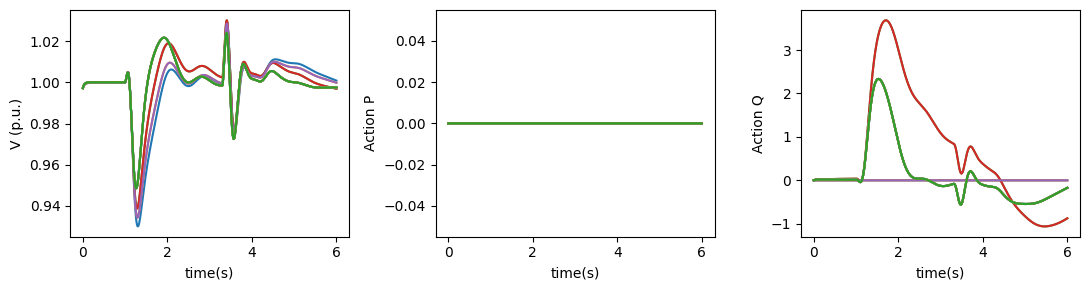

In [ ]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[]
Q_init_ratio = 0.7
P_init_ratio = 0.7
delta_t = 0.001
Q = 1*Q_ref
# 0*(Q_ref*np.random.uniform(1-Q_init_ratio ,1+Q_init_ratio ,(dim_action, 1))).T
# P = (P_ref*np.random.uniform(1-P_init_ratio ,1+P_init_ratio ,(dim_action, 1))).T
P = P_ref

s_concate=P@Matrix_R.T+Q@Matrix_X.T+ record_v0[0]
init_state=s_concate.copy()
s=init_state.copy()
SimulationLength=6000
# Record_u_Linear=[]
Record_up_Linear=[]
Record_uq_Linear=[]
Record_up_Linear.append(np.zeros(dim_action))
Record_uq_Linear.append(np.zeros(dim_action))
Trajectory_Linear.append(s)
Record_Loss_Linear=[]
Loss_Linear=0
print('s',s)
for i in range(1,SimulationLength):
    up=0*np.squeeze(Action_linear(s-1,linear_coffp))
    uq=np.squeeze(Action_linear(s-1,linear_coffq))
    p = Record_up_Linear[-1]- up
    q = Record_uq_Linear[-1]- uq
    q = np.minimum(np.maximum(q, q_min), q_max)
    next_s= (Q_ref+q)@Matrix_X + p@Matrix_R + record_v0[i]+ (P_ref)@Matrix_R
    # s - uq@Matrix_X - up@Matrix_R + record_v0[i]+ p_inj_diff[i]@Matrix_R
    s=next_s.copy()
    Trajectory_Linear.append(s.copy())
    Record_up_Linear.append(p.copy())
    Record_uq_Linear.append(q.copy())

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
fig = plt.figure(figsize=(11,3), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,1)
plt.plot(TimeRecord,Trajectory_Linear)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,2)
plt.plot(TimeRecord,Record_up_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action P')

plt.subplot(1,3,3)
plt.plot(TimeRecord,Record_uq_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action Q')
fig.tight_layout()


### Without control

s [0.99833549 0.99835366 0.99835366 0.99835366 0.99835366 0.99840325
 0.99840325 0.99840325 0.99840325 0.99840325 0.99840325 0.99840325
 0.99840325]


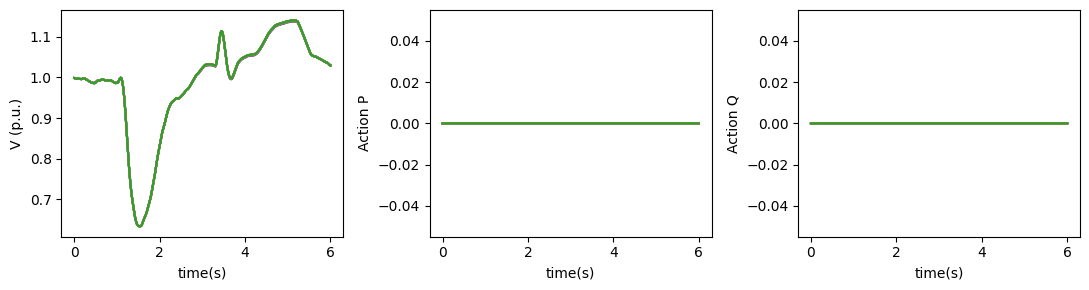

In [ ]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[]
Q_init_ratio = 0.7
P_init_ratio = 0.7
delta_t = 0.001
Q = 1*Q_ref
# 0*(Q_ref*np.random.uniform(1-Q_init_ratio ,1+Q_init_ratio ,(dim_action, 1))).T
# P = (P_ref*np.random.uniform(1-P_init_ratio ,1+P_init_ratio ,(dim_action, 1))).T
P = p_inj[0]
# P_ref
record_v0 = record_fault_trajectory[3,0,3,0:]

s_concate=P@Matrix_R.T+Q@Matrix_X.T+ record_v0[0]
init_state=s_concate.copy()
s=init_state.copy()
# SimulationLength=6000
# Record_u_Linear=[]
Record_up_Linear=[]
Record_uq_Linear=[]
Record_up_Linear.append(np.zeros(dim_action))
Record_uq_Linear.append(np.zeros(dim_action) )
Trajectory_Linear.append(s)
Record_Loss_Linear=[]
Loss_Linear=0
print('s',s)
for i in range(1,SimulationLength):
    up=0*np.squeeze(Action_linear(s-1,linear_coffp))
    uq=0*np.squeeze(Action_linear(s-1,linear_coffq))
    p = Record_up_Linear[-1]- up
    q = Record_uq_Linear[-1]- uq
    q = np.minimum(np.maximum(q, q_min), q_max)
    next_s= (Q_ref+q)@Matrix_X + p@Matrix_R + record_v0[i]+ (p_inj[i])@Matrix_R
    # s - uq@Matrix_X - up@Matrix_R + record_v0[i]+ p_inj_diff[i]@Matrix_R
    s=next_s.copy()
    Trajectory_Linear.append(s.copy())
    Record_up_Linear.append(p.copy())
    Record_uq_Linear.append(q.copy())

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
fig = plt.figure(figsize=(11,3), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,1)
plt.plot(TimeRecord,Trajectory_Linear)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,2)
plt.plot(TimeRecord,Record_up_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action P')

plt.subplot(1,3,3)
plt.plot(TimeRecord,Record_uq_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action Q')
fig.tight_layout()


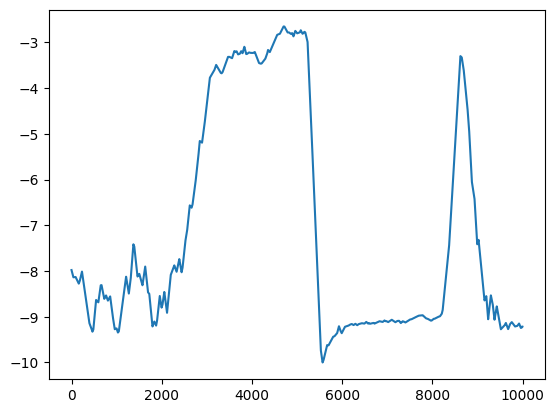

In [ ]:
plt.plot(p_inj[:,5])

# Init Simulation Diff

In [ ]:
#linear droop control
def Action_linear(state,linear_coff):
    action_nonconstrain = state*linear_coff
    action=action_nonconstrain
    # env.max_action-tf.nn.relu(env.max_action-action_nonconstrain)+tf.nn.relu(-env.max_action-action_nonconstrain)
    return action
def Action_constraints(action_nonconstrain):
    action=env.max_action-K.relu(env.max_action-action_nonconstrain)+K.relu(-env.max_action-action_nonconstrain)
    return action

In [ ]:

linear_coffp= np.random.uniform(low=1, high=1, size=(1,dim_action))*0.2
linear_coffq= np.random.uniform(low=1, high=1, size=(1,dim_action))*0.2
# linear_coffp= K_[0:dim_action].reshape((1,-1))
# linear_coffq= K_[dim_action:].reshape((1,-1))
action_units=dim_action

In [ ]:
p_inj_diff = np.diff(p_inj, axis=0)

Text(0, 0.5, ' P')

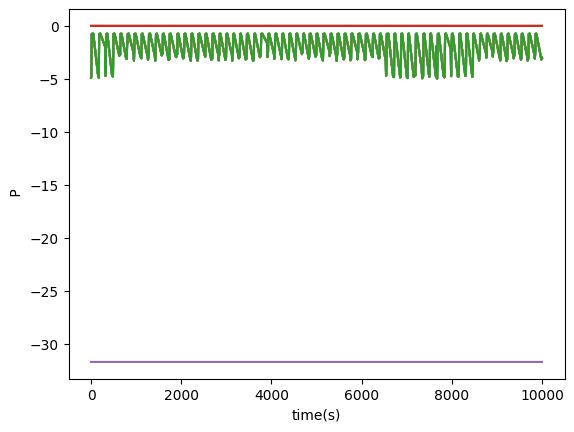

In [ ]:
TimeRecord=np.arange(0,p_inj.shape[0])

plt.plot(TimeRecord,p_inj)
plt.xlabel('time(s)')
plt.ylabel(' P')

Text(0, 0.5, ' P')

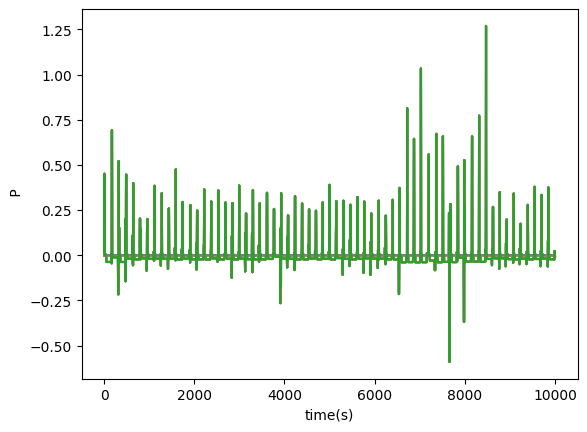

In [ ]:
TimeRecord=np.arange(0,p_inj_diff.shape[0])

plt.plot(TimeRecord,p_inj_diff)
plt.xlabel('time(s)')
plt.ylabel(' P')

### With V0 after fault, time-varying p

s [-2.77555756e-17 -2.77555756e-17 -3.46944695e-17 -2.77555756e-17
 -2.77555756e-17 -3.46944695e-17 -3.46944695e-17 -3.46944695e-17
 -4.16333634e-17 -3.46944695e-17 -3.46944695e-17 -3.46944695e-17
 -2.77555756e-17]


ValueError: x and y must have same first dimension, but have shapes (6000,) and (6001, 13)

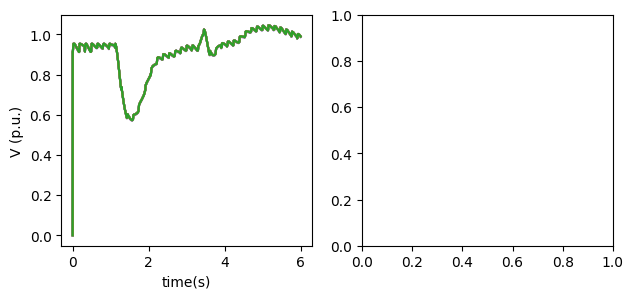

In [ ]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[]
Q_init_ratio = 0.7
P_init_ratio = 0.7
delta_t = 0.001
Q = 1*Q_ref
# 0*(Q_ref*np.random.uniform(1-Q_init_ratio ,1+Q_init_ratio ,(dim_action, 1))).T
# P = (P_ref*np.random.uniform(1-P_init_ratio ,1+P_init_ratio ,(dim_action, 1))).T
P = P_ref

s_concate=P@Matrix_R.T+Q@Matrix_X.T
init_state=s_concate.copy()
s=init_state.copy()
SimulationLength=6000
# Record_u_Linear=[]
Record_up_Linear=[]
Record_uq_Linear=[]
Record_up_Linear.append(P.copy())
Record_uq_Linear.append(Q.copy() )
Trajectory_Linear.append(s)
Record_Loss_Linear=[]
Loss_Linear=0
print('s',s)
record_v0 = record_fault_trajectory[3,0,3,0:]
for i in range(SimulationLength):
    up=np.squeeze(Action_linear(s,linear_coffp))
    uq=np.squeeze(Action_linear(s,linear_coffq))
    p = Record_up_Linear[-1]- up
    q = Record_uq_Linear[-1]- uq
    next_s= q@Matrix_X + p@Matrix_R + record_v0[i]+ p_inj[i]@Matrix_R
    # s - uq@Matrix_X - up@Matrix_R + record_v0[i]+ p_inj_diff[i]@Matrix_R
    s=next_s.copy()
    Trajectory_Linear.append(s.copy())
    Record_up_Linear.append(up.copy())
    Record_uq_Linear.append(uq.copy())

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
fig = plt.figure(figsize=(11,3), dpi=100)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,1)
plt.plot(TimeRecord,Trajectory_Linear)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,2)
plt.plot(TimeRecord,Record_up_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action P')

plt.subplot(1,3,3)
plt.plot(TimeRecord,Record_uq_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action Q')
fig.tight_layout()


s [-2.77555756e-17 -2.77555756e-17 -3.46944695e-17 -2.77555756e-17
 -2.77555756e-17 -3.46944695e-17 -3.46944695e-17 -3.46944695e-17
 -4.16333634e-17 -3.46944695e-17 -3.46944695e-17 -3.46944695e-17
 -2.77555756e-17]


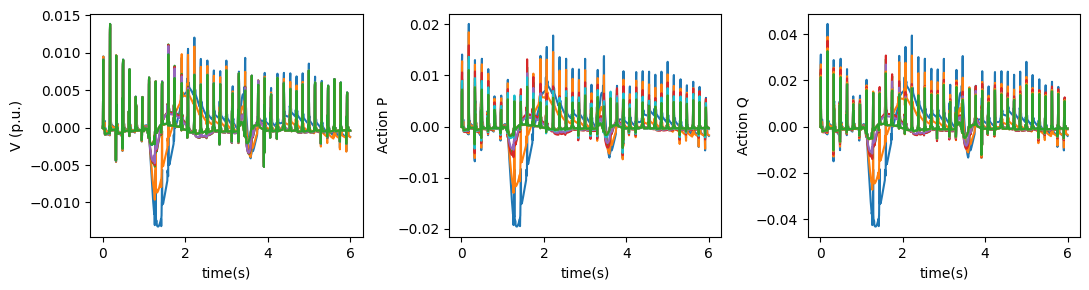

In [ ]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[]
Q_init_ratio = 0.7
P_init_ratio = 0.7
delta_t = 0.001
Q = 1*Q_ref
# 0*(Q_ref*np.random.uniform(1-Q_init_ratio ,1+Q_init_ratio ,(dim_action, 1))).T
# P = (P_ref*np.random.uniform(1-P_init_ratio ,1+P_init_ratio ,(dim_action, 1))).T
P = P_ref

s_concate=P@Matrix_R.T+Q@Matrix_X.T
init_state=s_concate.copy()
s=init_state.copy()
SimulationLength=6000
# Record_u_Linear=[]
Record_up_Linear=[]
Record_uq_Linear=[]
Trajectory_Linear.append(s)
Record_Loss_Linear=[]
Loss_Linear=0
print('s',s)
record_v0 = np.diff(record_fault_trajectory[3,0,3,0:])
for i in range(SimulationLength):
    up=np.squeeze(Action_linear(s,linear_coffp))
    uq=np.squeeze(Action_linear(s,linear_coffq))
    p = Record_up_Linear[-1]- up
    q = Record_uq_Linear[-1]- uq
    next_s= q@Matrix_X + p@Matrix_R
    # s - uq@Matrix_X - up@Matrix_R + record_v0[i]+ p_inj_diff[i]@Matrix_R
    s=next_s.copy()
    Trajectory_Linear.append(s.copy())
    Record_up_Linear.append(up.copy())
    Record_uq_Linear.append(uq.copy())

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
fig = plt.figure(figsize=(11,3), dpi=100)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,1)
plt.plot(TimeRecord,Trajectory_Linear)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,2)
plt.plot(TimeRecord,Record_up_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action P')

plt.subplot(1,3,3)
plt.plot(TimeRecord,Record_uq_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action Q')
fig.tight_layout()


In [ ]:
record_v0[1001]

np.float64(-0.00023096493934904316)

Text(0, 0.5, ' P')

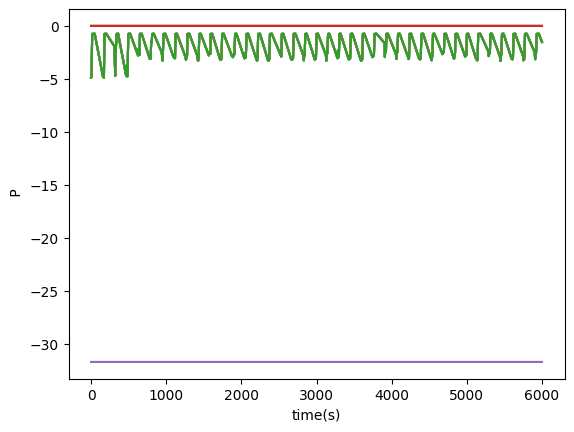

In [ ]:
TimeRecord=np.arange(0,SimulationLength)

plt.plot(TimeRecord,p_inj[:SimulationLength,:])
plt.xlabel('time(s)')
plt.ylabel(' P')

### With V0 after fault, constant p

s [-2.77555756e-17 -2.77555756e-17 -3.46944695e-17 -2.77555756e-17
 -2.77555756e-17 -3.46944695e-17 -3.46944695e-17 -3.46944695e-17
 -4.16333634e-17 -3.46944695e-17 -3.46944695e-17 -3.46944695e-17
 -2.77555756e-17]


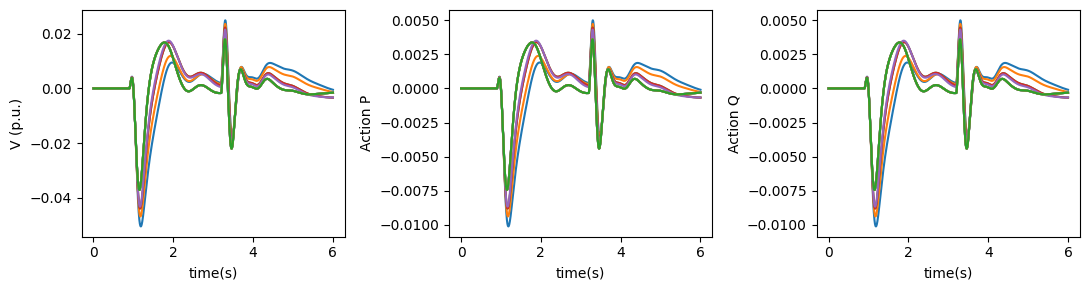

In [ ]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[]
# Q_init_ratio = 0.7
# P_init_ratio = 0.7
# Q = (Q_ref*np.random.uniform(1-Q_init_ratio ,1+Q_init_ratio ,(dim_action, 1))).T
# P = (P_ref*np.random.uniform(1-P_init_ratio ,1+P_init_ratio ,(dim_action, 1))).T

# s_concate=P@Matrix_R.T+Q@Matrix_X.T
init_state=s_concate.copy()
s=init_state.copy()
# Record_u_Linear=[]
Record_up_Linear=[]
Record_uq_Linear=[]
Trajectory_Linear.append(s)
Record_Loss_Linear=[]
Loss_Linear=0
print('s',s)
# record_v0 = np.diff(record_fault_trajectory[1,0,0,1:])
for i in range(SimulationLength):
    up=np.squeeze(Action_linear(s,linear_coffp))
    uq=np.squeeze(Action_linear(s,linear_coffq))
    next_s= s - uq@Matrix_X - up@Matrix_R + record_v0[i]
    s=next_s.copy()
    Trajectory_Linear.append(s.copy())
    Record_up_Linear.append(up.copy())
    Record_uq_Linear.append(uq.copy())

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
fig = plt.figure(figsize=(11,3), dpi=100)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,1)
plt.plot(TimeRecord,Trajectory_Linear)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,2)
plt.plot(TimeRecord,Record_up_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action P')

plt.subplot(1,3,3)
plt.plot(TimeRecord,Record_uq_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action Q')
fig.tight_layout()


### Without control

s [-2.77555756e-17 -2.77555756e-17 -3.46944695e-17 -2.77555756e-17
 -2.77555756e-17 -3.46944695e-17 -3.46944695e-17 -3.46944695e-17
 -4.16333634e-17 -3.46944695e-17 -3.46944695e-17 -3.46944695e-17
 -2.77555756e-17]


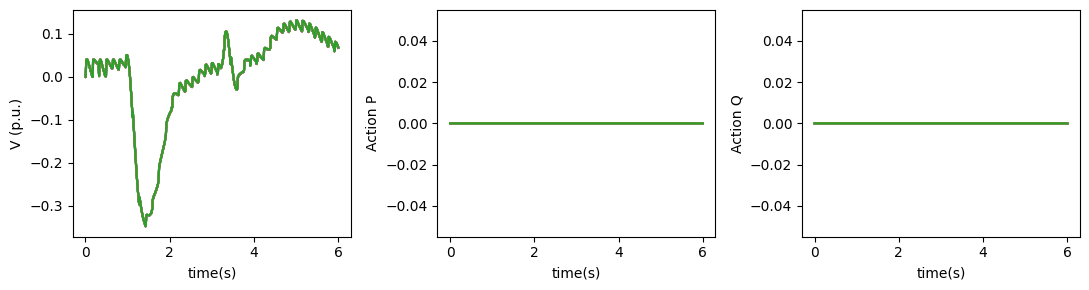

In [ ]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[]
# Q_init_ratio = 0.7
# P_init_ratio = 0.7
# Q = (Q_ref*np.random.uniform(1-Q_init_ratio ,1+Q_init_ratio ,(dim_action, 1))).T
# P = (P_ref*np.random.uniform(1-P_init_ratio ,1+P_init_ratio ,(dim_action, 1))).T

# s_concate=P@Matrix_R.T+Q@Matrix_X.T
init_state=s_concate.copy()
s=init_state.copy()
# SimulationLength=2000
# Record_u_Linear=[]
Record_up_Linear=[]
Record_uq_Linear=[]
Trajectory_Linear.append(s)
Record_Loss_Linear=[]
Loss_Linear=0
print('s',s)
# record_v0 = np.diff(record_fault_trajectory[3,0,3,1100:])
for i in range(SimulationLength):
    up=np.squeeze(Action_linear(s,linear_coffp))*0
    uq=np.squeeze(Action_linear(s,linear_coffq))*0
    next_s= s - uq@Matrix_X - up@Matrix_R + record_v0[i]+ p_inj_diff[i]@Matrix_R
    s=next_s.copy()
    Trajectory_Linear.append(s.copy())
    Record_up_Linear.append(up.copy())
    Record_uq_Linear.append(uq.copy())

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
fig = plt.figure(figsize=(11,3), dpi=100)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,1)
plt.plot(TimeRecord,Trajectory_Linear)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,2)
plt.plot(TimeRecord,Record_up_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action P')

plt.subplot(1,3,3)
plt.plot(TimeRecord,Record_uq_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action Q')
fig.tight_layout()


### With constant

s [-2.77555756e-17 -2.77555756e-17 -3.46944695e-17 -2.77555756e-17
 -2.77555756e-17 -3.46944695e-17 -3.46944695e-17 -3.46944695e-17
 -4.16333634e-17 -3.46944695e-17 -3.46944695e-17 -3.46944695e-17
 -2.77555756e-17]


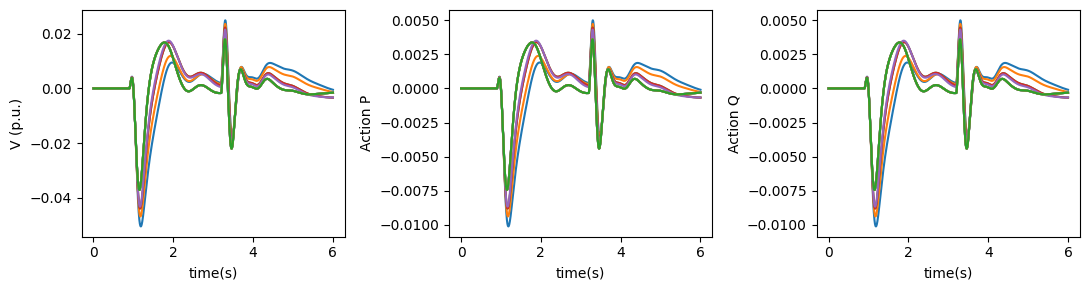

In [ ]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[]
# Q_init_ratio = 0.7
# P_init_ratio = 0.7
# delta_t = 1
# Q = (Q_ref*np.random.uniform(1-Q_init_ratio ,1+Q_init_ratio ,(dim_action, 1))).T
# P = (P_ref*np.random.uniform(1-P_init_ratio ,1+P_init_ratio ,(dim_action, 1))).T

# s_concate=P@Matrix_R.T+Q@Matrix_X.T
init_state=s_concate.copy()
s=init_state.copy()
# SimulationLength=1000
# Record_u_Linear=[]
Record_up_Linear=[]
Record_uq_Linear=[]
Trajectory_Linear.append(s)
Record_Loss_Linear=[]
Loss_Linear=0
print('s',s)
# record_v0 =0* np.diff(record_fault_trajectory[0,0,0,1100:])
for i in range(SimulationLength):
    up=np.squeeze(Action_linear(s,linear_coffp))
    uq=np.squeeze(Action_linear(s,linear_coffq))
    next_s= s - uq@Matrix_X - up@Matrix_R + record_v0[i]
    s=next_s.copy()
    Trajectory_Linear.append(s.copy())
    Record_up_Linear.append(up.copy())
    Record_uq_Linear.append(uq.copy())

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
fig = plt.figure(figsize=(11,3), dpi=100)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,1)
plt.plot(TimeRecord,Trajectory_Linear)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,2)
plt.plot(TimeRecord,Record_up_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action P')

plt.subplot(1,3,3)
plt.plot(TimeRecord,Record_uq_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action Q')
fig.tight_layout()


# Training -q

In [ ]:
class RNNModel(tf.keras.Model):
    def __init__(self, cell):
        super().__init__()
        self.rnn = tf.keras.layers.RNN(cell, return_sequences=True, stateful=True)

    def call(self, inputs, initial_state=None):
        return self.rnn(inputs, initial_state=initial_state)

In [ ]:
# RNN Cell to integrate state transition dynamics
class MinimalRNNCellLinear0(keras.layers.Layer):

    def __init__(self, units,action_units,internal_units,env,batchsize,K_boundq, K_boundp,**kwargs):
        self.units = units
        self.action_units = action_units
        self.state_size = units
        self.internal_units = internal_units
        self.batchsize=batchsize
        self.Matrix_X=tf.constant(env.Matrix_X,dtype=tf.float32)
        self.Matrix_R=tf.constant(env.Matrix_R,dtype=tf.float32)
        self.inv_Matrix_X = tf.constant(env.inv_Matrix_X,dtype=tf.float32)
        self.lambda_max = tf.constant(env.lambda_max,dtype=tf.float32)
        self.max_action=tf.constant(env.max_action,dtype=tf.float32)
        self.bound_slopq = tf.constant(K_boundq.reshape((1,-1)),dtype=tf.float32)
        self.bound_slopp = tf.constant(K_boundp.reshape((1,-1)),dtype=tf.float32)
        self.norm_q=1
        super(MinimalRNNCellLinear0, self).__init__(**kwargs)

    def build(self, input_shape):


        self.linear_Kq= self.add_weight(
            shape=(1,self.action_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0.1, maxval=0.5),
            trainable=True,
            constraint=tf.keras.constraints.NonNeg(),
            name='linear_Kq')
        self.built = True

    def call(self, inputs_concate, states):
        # stacked ReLU structure to represent control network
        prev_state = states[0]
        prev_state_x = prev_state[:,0:self.action_units]
        prev_state_q =  prev_state[:,self.action_units:2*self.action_units]
        inputs_p = inputs_concate[:,0:self.action_units]
        inputs_v0 = inputs_concate[:,self.action_units:self.action_units+1]


        linear_Kq_=tf.math.minimum(self.linear_Kq, self.bound_slopq )
        action_q= K.sum(tf.linalg.diag(prev_state_x-1)*linear_Kq_,axis=2)
        action_nonconstrain = prev_state_q - action_q
        new_state_q=self.max_action-K.relu(self.max_action-action_nonconstrain)+K.relu(-self.max_action-action_nonconstrain)

        new_state_x=K.dot(new_state_q, tf.transpose(self.Matrix_X))+ K.dot(inputs_p, tf.transpose(self.Matrix_R)) + K.dot(inputs_v0, tf.ones((1,self.action_units)))

        next_state =  tf.concat([new_state_x, new_state_q], axis = 1)


        return [new_state_x,action_q, new_state_q], [next_state]




In [ ]:
p_inj_diff = np.diff(p_inj, axis=0)

In [ ]:
episodes =1000 # total number of iterations to update weights
action_units=dim_action
units=action_units*2 #dimension of each state
internal_units=20 # demension of the neural network for control policy

T=100  #Total period considered
Batch_num=500 # number of batch in each episodes
learning_rate_initial=0.01
decay_stage = 100
decay_rate = 0.9

cellLinear0 = MinimalRNNCellLinear0(units,action_units,internal_units,env,Batch_num,K_bound_q,K_bound_p)
modelLinear0 = RNNModel(cellLinear0)

Loss_record=[]
Pe_rnn_record=[]
global_step = tf.Variable(0, trainable=False)
decayed_lr =tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate_initial, decay_stage, decay_rate, staircase=True)
optimizer=tf.keras.optimizers.Adam(learning_rate=decayed_lr)

Length_pred_dataset = p_inj_diff.shape[0]-100
column1_idx = np.arange(0,dim_action)
PrintUpdate = 1
for i in range(0,episodes):
    initial_state_q = np.zeros((Batch_num,action_units))
    # (1- np.random.uniform(-Q_init_ratio,Q_init_ratio,(Batch_num,action_units)))*(Q_ref.T)
    # initial_state_p = (1- np.random.uniform(-P_init_ratio,P_init_ratio,(Batch_num,action_units)))*(P_ref.T)
    initial_state=np.ones((Batch_num,action_units))

    Input_config = np.zeros((Batch_num,T,dim_action+1))
    for j in range(Batch_num):
       #### time varying p
       t_init_Pm = np.random.randint(0, Length_pred_dataset-T-1)
       Input_config[j,:,:dim_action]=(p_inj[t_init_Pm:t_init_Pm+T,:]-p_inj[0,:])
       ###### v0
       rand_fault_idx = np.random.randint(0,np.shape(record_fault_trajectory)[0])
       rand_time_idx = np.random.randint(1050,1150)
       rand_bus_idx = np.random.randint(0,np.shape(record_fault_trajectory)[2])
       Input_config[j,:,dim_action] = record_fault_trajectory[rand_fault_idx,0,rand_bus_idx,rand_time_idx:rand_time_idx+T]


    with tf.GradientTape(persistent=True) as tape:
        [voltage,action_q,record_q]=modelLinear0(Input_config, np.hstack((initial_state, initial_state_q)))
        loss_voltage=K.sum(K.sum(K.abs(voltage)))/Batch_num/T/dim_action
        loss_action=0.0001*(env.Penalty_action*K.sum(abs(record_q)))/Batch_num/T/dim_action
        loss=loss_voltage+loss_action
    grads = tape.gradient(loss, modelLinear0.variables)
    optimizer.apply_gradients(zip(grads, modelLinear0.variables))
    Loss_record.append(loss)



    if i % (PrintUpdate) == 0:
        print('episode',i, 'Loss',loss)
        print('         Loss_Voltage',loss_voltage, '  loss_action', loss_action)



episode 0 Loss tf.Tensor(1.0035794, shape=(), dtype=float32)
         Loss_Voltage tf.Tensor(1.003578, shape=(), dtype=float32)   loss_action tf.Tensor(1.3807386e-06, shape=(), dtype=float32)
episode 1 Loss tf.Tensor(1.0042769, shape=(), dtype=float32)
         Loss_Voltage tf.Tensor(1.0042754, shape=(), dtype=float32)   loss_action tf.Tensor(1.4357413e-06, shape=(), dtype=float32)
episode 2 Loss tf.Tensor(1.0044832, shape=(), dtype=float32)
         Loss_Voltage tf.Tensor(1.0044818, shape=(), dtype=float32)   loss_action tf.Tensor(1.4550606e-06, shape=(), dtype=float32)
episode 3 Loss tf.Tensor(1.0033331, shape=(), dtype=float32)
         Loss_Voltage tf.Tensor(1.0033317, shape=(), dtype=float32)   loss_action tf.Tensor(1.4439182e-06, shape=(), dtype=float32)
episode 4 Loss tf.Tensor(1.0039202, shape=(), dtype=float32)
         Loss_Voltage tf.Tensor(1.0039186, shape=(), dtype=float32)   loss_action tf.Tensor(1.5121045e-06, shape=(), dtype=float32)
episode 5 Loss tf.Tensor(1.003134, s

In [ ]:
p_inj.shape

(999, 7)

In [ ]:
episodes =1000 # total number of iterations to update weights
action_units=dim_action
units=action_units*3 #dimension of each state
internal_units=20 # demension of the neural network for control policy

T=100  #Total period considered
Batch_num=500 # number of batch in each episodes
learning_rate_initial=0.01
decay_stage = 100
decay_rate = 0.9

cellLinear0 = MinimalRNNCellLinear0(units,action_units,internal_units,env,Batch_num,K_bound_q,K_bound_p)
modelLinear0 = RNNModel(cellLinear0)

Loss_record=[]
Pe_rnn_record=[]
global_step = tf.Variable(0, trainable=False)
decayed_lr =tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate_initial, decay_stage, decay_rate, staircase=True)
optimizer=tf.keras.optimizers.Adam(learning_rate=decayed_lr)



Text(0, 0.5, 'Loss')

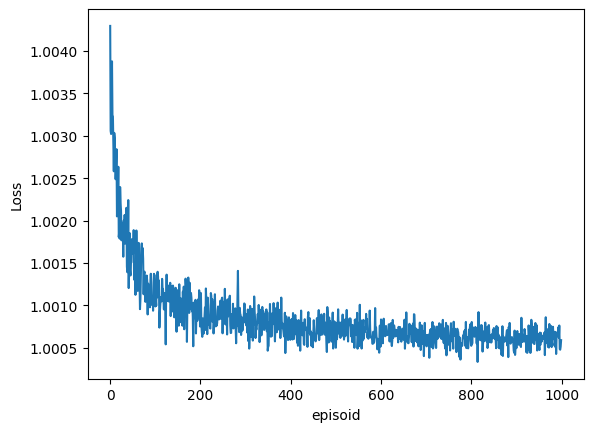

In [ ]:
plt.plot(Loss_record)
plt.xlabel('episoid')
plt.ylabel('Loss')
# plt.title('Non-Discounted Loss without penalty')

In [ ]:
modelLinear0.save_weights('/content/drive/MyDrive/Colab Notebooks/250805 data center/data/weights_Microsoft_K_250901_n8_q_t001.weights.h5')
# modelLinear0.load_weights('/content/drive/MyDrive/Colab Notebooks/250805 data center/data/weights_K_250808_t001.weights.h5')
# modelLinear0.load_weights('/content/drive/MyDrive/Colab Notebooks/250805 data center/data/weights_Vulcan_K_250808_n8_t001.weights.h5')


## Simulation and Comparisons

### With trained controller

s [0.96762388 0.96715045 0.96715045 0.96715045 0.96715045 0.96585876
 0.96585876 0.96585876 0.96585876 0.96585876 0.96585876 0.96585876
 0.96585876]


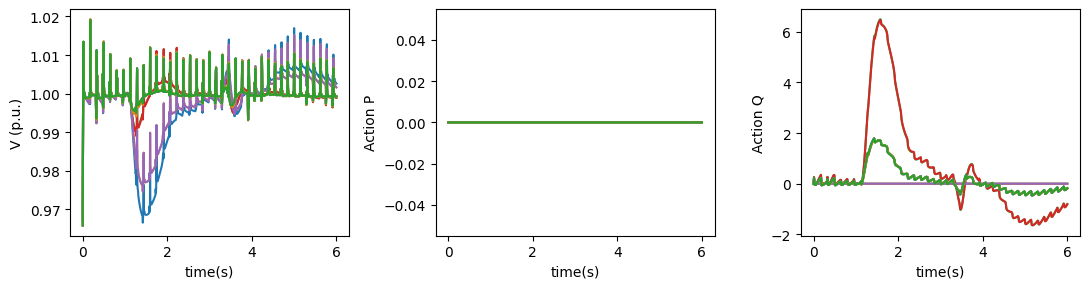

In [ ]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[]
Q_init_ratio = 0.7
P_init_ratio = 0.7
delta_t = 0.001
Q = 1*Q_ref
linear_coffq = tf.math.minimum(modelLinear0.variables[0], K_bound_q)

# 0*(Q_ref*np.random.uniform(1-Q_init_ratio ,1+Q_init_ratio ,(dim_action, 1))).T
# P = (P_ref*np.random.uniform(1-P_init_ratio ,1+P_init_ratio ,(dim_action, 1))).T
P = p_inj[0]
# P_ref
record_v0 = record_fault_trajectory[3,0,3,0:]

s_concate=P@Matrix_R.T+Q@Matrix_X.T+ record_v0[0]
init_state=s_concate.copy()
s=init_state.copy()
SimulationLength=6000
# Record_u_Linear=[]
Record_up_Linear=[]
Record_uq_Linear=[]
Record_up_Linear.append(np.zeros(dim_action))
Record_uq_Linear.append(np.zeros(dim_action) )
Trajectory_Linear.append(s)
Record_Loss_Linear=[]
Loss_Linear=0
print('s',s)
for i in range(1,SimulationLength):
    up=0*np.squeeze(Action_linear(s-1,linear_coffp))
    uq=np.squeeze(Action_linear(s-1,linear_coffq))
    p = Record_up_Linear[-1]- up
    q = Record_uq_Linear[-1]- uq
    q = np.minimum(np.maximum(q, q_min), q_max)
    next_s= (Q_ref+q)@Matrix_X + p@Matrix_R + record_v0[i]+ (p_inj[i])@Matrix_R
    # s - uq@Matrix_X - up@Matrix_R + record_v0[i]+ p_inj_diff[i]@Matrix_R
    s=next_s.copy()
    Trajectory_Linear.append(s.copy())
    Record_up_Linear.append(p.copy())
    Record_uq_Linear.append(q.copy())

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
fig = plt.figure(figsize=(11,3), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,1)
plt.plot(TimeRecord,Trajectory_Linear)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,2)
plt.plot(TimeRecord,Record_up_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action P')

plt.subplot(1,3,3)
plt.plot(TimeRecord,Record_uq_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action Q')
fig.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/250805 data center/figure/exp_decentralized_F4_q.png', bbox_inches='tight', dpi=600)


In [ ]:
q_min

array([   0.,    0., -100., -100.,    0.,   -4.,   -4.,   -4.,   -4.,
         -4.,   -4.,   -4.,   -4.])

In [ ]:
q_max

array([  0.,   0., 100., 100.,   0.,   4.,   4.,   4.,   4.,   4.,   4.,
         4.,   4.])

s [-2.77555756e-17 -2.77555756e-17 -3.46944695e-17 -2.77555756e-17
 -2.77555756e-17 -3.46944695e-17 -3.46944695e-17 -3.46944695e-17
 -4.16333634e-17 -3.46944695e-17 -3.46944695e-17 -3.46944695e-17
 -2.77555756e-17]


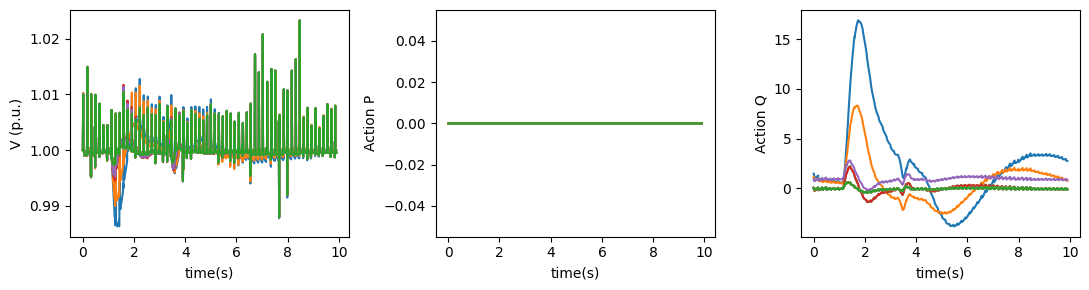

In [ ]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[]
# Q_init_ratio = 0.7
# P_init_ratio = 0.7
# delta_t = 0.001
Q = Q_ref
# # 0*(Q_ref*np.random.uniform(1-Q_init_ratio ,1+Q_init_ratio ,(dim_action, 1))).T
# # P = (P_ref*np.random.uniform(1-P_init_ratio ,1+P_init_ratio ,(dim_action, 1))).T
P = P_ref
linear_coffq = tf.math.minimum(modelLinear0.variables[0], K_bound_q)

s_concate=P@Matrix_R.T+Q@Matrix_X.T
init_state=s_concate.copy()
s=init_state.copy()
SimulationLength=10000-100
# Record_u_Linear=[]
Record_up_Linear=[]
Record_uq_Linear=[]
Record_uq_Linear.append(Q)
Trajectory_Linear.append(s)
Record_Loss_Linear=[]
Loss_Linear=0
print('s',s)
record_v0 = np.diff(record_fault_trajectory[3,0,3,0:])
for i in range(SimulationLength):
    uq=np.squeeze(Action_linear(s,linear_coffq))
    next_s= s - uq@Matrix_X + record_v0[i]+ p_inj_diff[i]@Matrix_R
    s=next_s.copy()
    Trajectory_Linear.append(s.copy())
    Record_uq_Linear.append(Record_uq_Linear[-1]-uq.copy())

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
fig = plt.figure(figsize=(11,3), dpi=100)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,1)
plt.plot(TimeRecord,Trajectory_Linear+1)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=delta_t*TimeRecord
Record_up_Linear = np.zeros((SimulationLength+1,dim_action))
plt.subplot(1,3,2)
plt.plot(TimeRecord,Record_up_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action P')

plt.subplot(1,3,3)
plt.plot(TimeRecord,Record_uq_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action Q')
fig.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/250805 data center/figure/exp_decentralized_F4_q.png', bbox_inches='tight', dpi=600)


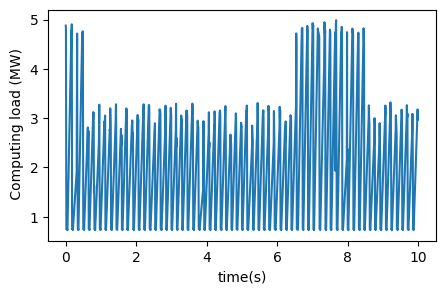

In [ ]:
TimeRecord=delta_t*np.arange(0,p_inj.shape[0])
fig = plt.figure(figsize=(5,3), dpi=100)

plt.plot(TimeRecord,-p_inj[:,6])
plt.xlabel('time(s)')
plt.ylabel(' Computing load (MW)')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/250805 data center/figure/Computing Load.png', bbox_inches='tight', dpi=600)


In [ ]:
p_inj.shape

(9999, 7)

### without control

s [-2.77555756e-17 -2.77555756e-17 -3.46944695e-17 -2.77555756e-17
 -2.77555756e-17 -3.46944695e-17 -3.46944695e-17 -3.46944695e-17
 -4.16333634e-17 -3.46944695e-17 -3.46944695e-17 -3.46944695e-17
 -2.77555756e-17]


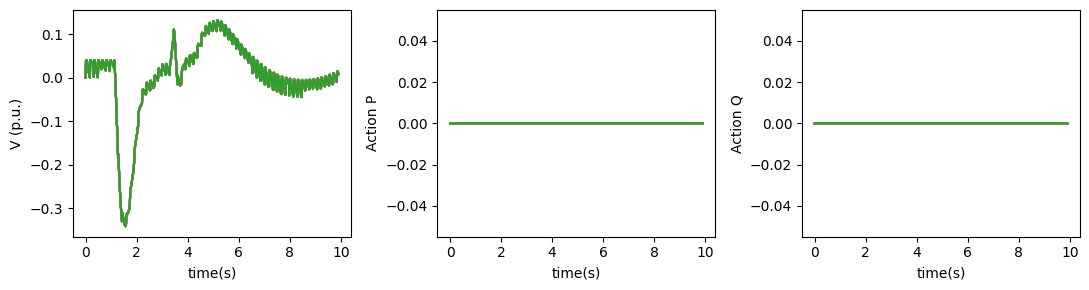

In [ ]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[]
Q_init_ratio = 0.7
P_init_ratio = 0.7
delta_t = 0.001
Q = 1*Q_ref
# 0*(Q_ref*np.random.uniform(1-Q_init_ratio ,1+Q_init_ratio ,(dim_action, 1))).T
# P = (P_ref*np.random.uniform(1-P_init_ratio ,1+P_init_ratio ,(dim_action, 1))).T
P = P_ref
linear_coffp = tf.math.minimum(modelLinear0.variables[0], K_bound_p)*0
linear_coffq = tf.math.minimum(modelLinear0.variables[0], K_bound_q)*0

s_concate=P@Matrix_R.T+Q@Matrix_X.T
init_state=s_concate.copy()
s=init_state.copy()
# SimulationLength=6000
# Record_u_Linear=[]
Record_up_Linear=[]
Record_uq_Linear=[]
Trajectory_Linear.append(s)
Record_Loss_Linear=[]
Loss_Linear=0
print('s',s)
# record_v0 = np.diff(record_fault_trajectory[0,0,0,0:])
for i in range(SimulationLength):
    up=np.squeeze(Action_linear(s,linear_coffp))
    uq=np.squeeze(Action_linear(s,linear_coffq))
    next_s= s - uq@Matrix_X - up@Matrix_R + record_v0[i]+ p_inj_diff[i]@Matrix_R
    s=next_s.copy()
    Trajectory_Linear.append(s.copy())
    Record_up_Linear.append(up.copy())
    Record_uq_Linear.append(uq.copy())

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
fig = plt.figure(figsize=(11,3), dpi=100)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,1)
plt.plot(TimeRecord,Trajectory_Linear)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,2)
plt.plot(TimeRecord,Record_up_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action P')

plt.subplot(1,3,3)
plt.plot(TimeRecord,Record_uq_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action Q')
fig.tight_layout()
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/250805 data center/figure/WoControl.png', bbox_inches='tight', dpi=600)


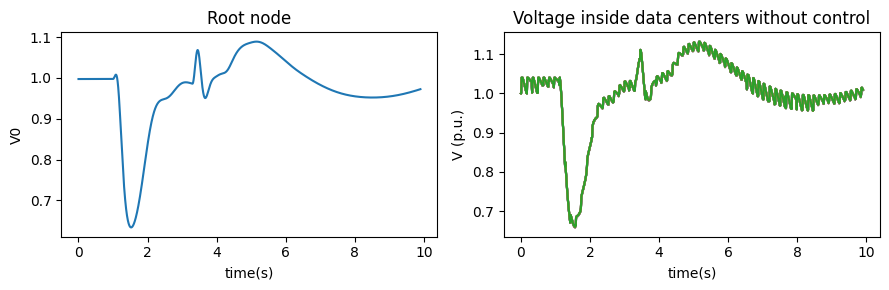

In [ ]:
fig = plt.figure(figsize=(9,3), dpi=100)

TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,2,2)
plt.plot(TimeRecord,Trajectory_Linear+1)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')
plt.title('Voltage inside data centers without control')
plt.subplot(1,2,1)
plt.plot(TimeRecord,record_fault_trajectory[3,0,3,0:SimulationLength+1])
plt.xlabel('time(s)')
plt.ylabel('V0')
plt.title('Root node')
fig.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/250805 data center/figure/exp_no_control_F4.png', bbox_inches='tight', dpi=600)


# Training - pg-diff

In [ ]:
class RNNModel(tf.keras.Model):
    def __init__(self, cell):
        super().__init__()
        self.rnn = tf.keras.layers.RNN(cell, return_sequences=True, stateful=True)

    def call(self, inputs, initial_state=None):
        return self.rnn(inputs, initial_state=initial_state)

In [ ]:
# RNN Cell to integrate state transition dynamics
class MinimalRNNCellLinear0(keras.layers.Layer):

    def __init__(self, units,action_units,internal_units,env,batchsize,K_boundq, K_boundp,**kwargs):
        self.units = units
        self.action_units = action_units
        self.state_size = units
        self.internal_units = internal_units
        self.batchsize=batchsize
        self.Matrix_X=tf.constant(env.Matrix_X,dtype=tf.float32)
        self.Matrix_R=tf.constant(env.Matrix_R,dtype=tf.float32)
        self.inv_Matrix_X = tf.constant(env.inv_Matrix_X,dtype=tf.float32)
        self.lambda_max = tf.constant(env.lambda_max,dtype=tf.float32)
        self.max_action=tf.constant(env.max_action,dtype=tf.float32)
        self.bound_slopq = tf.constant(K_boundq.reshape((1,-1)),dtype=tf.float32)
        self.bound_slopp = tf.constant(K_boundp.reshape((1,-1)),dtype=tf.float32)
        self.norm_q=1
        super(MinimalRNNCellLinear0, self).__init__(**kwargs)

    def build(self, input_shape):
        self.linear_Kp= self.add_weight(
            shape=(1,self.action_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0.1, maxval=0.5),
            trainable=True,
            constraint=tf.keras.constraints.NonNeg(),
            name='linear_Kp')

        self.linear_Kq= self.add_weight(
            shape=(1,self.action_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0.1, maxval=0.5),
            trainable=True,
            constraint=tf.keras.constraints.NonNeg(),
            name='linear_Kq')
        self.built = True

    def call(self, inputs_concate, states):
        # stacked ReLU structure to represent control network
        prev_state = states[0]
        prev_state_x = prev_state[:,0:self.action_units]
        prev_state_q =  prev_state[:,self.action_units:2*self.action_units]
        prev_state_p =  prev_state[:,2*self.action_units:3*self.action_units]
        inputs_p = inputs_concate[:,0:self.action_units]
        inputs_v0 = inputs_concate[:,self.action_units:self.action_units+1]


        linear_Kq_=tf.math.minimum(self.linear_Kq, self.bound_slopq )
        linear_Kp_=tf.math.minimum(self.linear_Kp, self.bound_slopp )
        action_q= K.sum(tf.linalg.diag(prev_state_x)*linear_Kq_,axis=2)
        action_p= K.sum(tf.linalg.diag(prev_state_x)*linear_Kp_,axis=2)
        # action=self.max_action-K.relu(self.max_action-action_nonconstrain)+K.relu(-self.max_action-action_nonconstrain)
        new_state_x=prev_state_x-K.dot(action_q, tf.transpose(self.Matrix_X))-K.dot(action_p, tf.transpose(self.Matrix_R))+ K.dot(inputs_p, tf.transpose(self.Matrix_R)) + K.dot(inputs_v0, tf.ones((1,self.action_units)))
        new_state_q = prev_state_q - action_q
        new_state_p = prev_state_p - action_p

        next_state =  tf.concat([new_state_x, new_state_q, new_state_p], axis = 1)


        return [new_state_x,action_q, action_p, new_state_q, new_state_p], [next_state]




In [ ]:
p_inj_diff = np.diff(p_inj, axis=0)

In [ ]:
episodes =1000 # total number of iterations to update weights
action_units=dim_action
units=action_units*3 #dimension of each state
internal_units=20 # demension of the neural network for control policy

T=100  #Total period considered
Batch_num=500 # number of batch in each episodes
learning_rate_initial=0.01
decay_stage = 100
decay_rate = 0.9

cellLinear0 = MinimalRNNCellLinear0(units,action_units,internal_units,env,Batch_num,K_bound_q,K_bound_p)
modelLinear0 = RNNModel(cellLinear0)

Loss_record=[]
Pe_rnn_record=[]
global_step = tf.Variable(0, trainable=False)
decayed_lr =tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate_initial, decay_stage, decay_rate, staircase=True)
optimizer=tf.keras.optimizers.Adam(learning_rate=decayed_lr)

Length_pred_dataset = p_inj_diff.shape[0]-100
column1_idx = np.arange(0,dim_action)
PrintUpdate = 1
for i in range(0,episodes):
    initial_state_q = (1- np.random.uniform(-Q_init_ratio,Q_init_ratio,(Batch_num,action_units)))*(Q_ref.T)
    initial_state_p = (1- np.random.uniform(-P_init_ratio,P_init_ratio,(Batch_num,action_units)))*(P_ref.T)
    initial_state=initial_state_p@Matrix_R.T+initial_state_q@Matrix_X.T

    Input_config = np.zeros((Batch_num,T,dim_action+1))
    for j in range(Batch_num):
       #### time varying p
       t_init_Pm = np.random.randint(0, Length_pred_dataset-T-1)
       Input_config[j,:,:dim_action]=p_inj_diff[t_init_Pm:t_init_Pm+T,:]
       ###### v0
       rand_fault_idx = np.random.randint(0,np.shape(record_fault_trajectory)[0])
       rand_time_idx = np.random.randint(1050,1150)
       rand_bus_idx = np.random.randint(0,np.shape(record_fault_trajectory)[2])
       Input_config[j,:,dim_action] = record_fault_trajectory[rand_fault_idx,0,rand_bus_idx,rand_time_idx:rand_time_idx+T]


    with tf.GradientTape(persistent=True) as tape:
        [voltage,action_q,action_p, record_q, record_p]=modelLinear0(Input_config, np.hstack((initial_state, initial_state_q, initial_state_p)))
        loss_voltage=K.sum(K.sum(K.abs(voltage)))/Batch_num/T/dim_action
        loss_action=0.01*(env.Penalty_action*K.sum(abs(record_q)))/Batch_num/T/dim_action + 0.01*(env.Penalty_action*K.sum(abs(record_p)))/Batch_num/T/dim_action
        loss=loss_voltage+loss_action
    grads = tape.gradient(loss, modelLinear0.variables)
    optimizer.apply_gradients(zip(grads, modelLinear0.variables))
    Loss_record.append(loss)



    if i % (PrintUpdate) == 0:
        print('episode',i, 'Loss',loss)
        print('         Loss_Voltage',loss_voltage, '  loss_action', loss_action)



episode 0 Loss tf.Tensor(15.878176, shape=(), dtype=float32)
         Loss_Voltage tf.Tensor(15.491846, shape=(), dtype=float32)   loss_action tf.Tensor(0.3863296, shape=(), dtype=float32)
episode 1 Loss tf.Tensor(15.476242, shape=(), dtype=float32)
         Loss_Voltage tf.Tensor(15.0854435, shape=(), dtype=float32)   loss_action tf.Tensor(0.390799, shape=(), dtype=float32)
episode 2 Loss tf.Tensor(15.041002, shape=(), dtype=float32)
         Loss_Voltage tf.Tensor(14.647262, shape=(), dtype=float32)   loss_action tf.Tensor(0.39374077, shape=(), dtype=float32)
episode 3 Loss tf.Tensor(14.650449, shape=(), dtype=float32)
         Loss_Voltage tf.Tensor(14.253488, shape=(), dtype=float32)   loss_action tf.Tensor(0.39696103, shape=(), dtype=float32)


KeyboardInterrupt: 

In [ ]:
p_inj.shape

(999, 7)

In [ ]:
episodes =1000 # total number of iterations to update weights
action_units=dim_action
units=action_units*3 #dimension of each state
internal_units=20 # demension of the neural network for control policy

T=100  #Total period considered
Batch_num=500 # number of batch in each episodes
learning_rate_initial=0.01
decay_stage = 100
decay_rate = 0.9

cellLinear0 = MinimalRNNCellLinear0(units,action_units,internal_units,env,Batch_num,K_bound_q,K_bound_p)
modelLinear0 = RNNModel(cellLinear0)

Loss_record=[]
Pe_rnn_record=[]
global_step = tf.Variable(0, trainable=False)
decayed_lr =tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate_initial, decay_stage, decay_rate, staircase=True)
optimizer=tf.keras.optimizers.Adam(learning_rate=decayed_lr)



Text(0, 0.5, 'Loss')

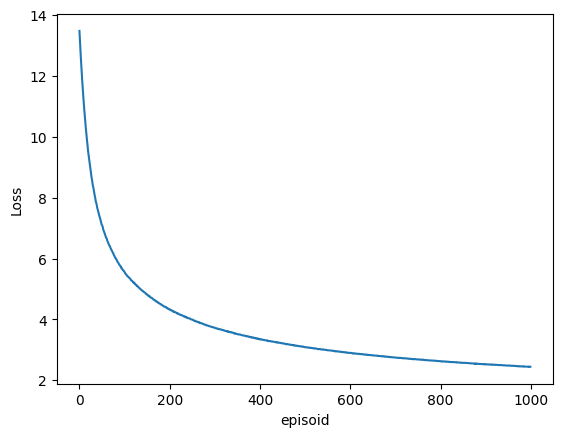

In [ ]:
plt.plot(Loss_record)
plt.xlabel('episoid')
plt.ylabel('Loss')
# plt.title('Non-Discounted Loss without penalty')

In [ ]:
# modelLinear0.save_weights('/content/drive/MyDrive/Colab Notebooks/250805 data center/data/weights_Vulcan_K_250808_n8_t001.weights.h5')
# modelLinear0.load_weights('/content/drive/MyDrive/Colab Notebooks/250805 data center/data/weights_K_250808_t001.weights.h5')
modelLinear0.load_weights('/content/drive/MyDrive/Colab Notebooks/250805 data center/data/weights_Vulcan_K_250808_n8_t001.weights.h5')


## Simulation and Comparisons

### With trained controller

s [-2.77555756e-17 -2.77555756e-17 -3.46944695e-17 -2.77555756e-17
 -2.77555756e-17 -3.46944695e-17 -3.46944695e-17 -3.46944695e-17
 -4.16333634e-17 -3.46944695e-17 -3.46944695e-17 -3.46944695e-17
 -2.77555756e-17]


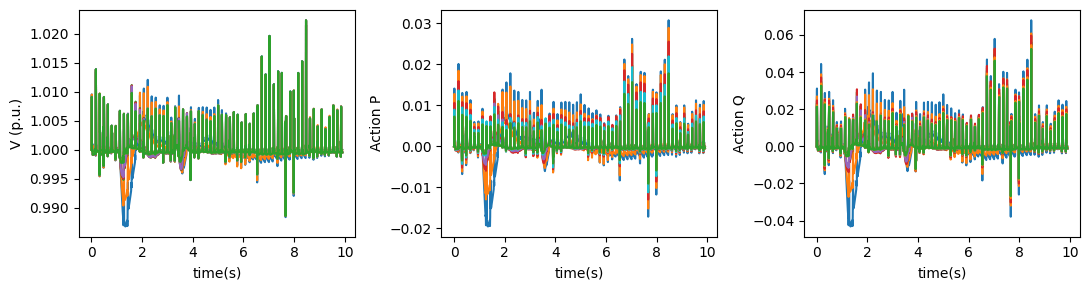

In [ ]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[]
# Q_init_ratio = 0.7
# P_init_ratio = 0.7
# delta_t = 0.001
Q = Q_ref
# # 0*(Q_ref*np.random.uniform(1-Q_init_ratio ,1+Q_init_ratio ,(dim_action, 1))).T
# # P = (P_ref*np.random.uniform(1-P_init_ratio ,1+P_init_ratio ,(dim_action, 1))).T
P = P_ref
linear_coffp = tf.math.minimum(modelLinear0.variables[0], K_bound_p)
linear_coffq = tf.math.minimum(modelLinear0.variables[1], K_bound_q)

s_concate=P@Matrix_R.T+Q@Matrix_X.T
init_state=s_concate.copy()
s=init_state.copy()
SimulationLength=10000-100
# Record_u_Linear=[]
Record_up_Linear=[]
Record_uq_Linear=[]
Trajectory_Linear.append(s)
Record_Loss_Linear=[]
Loss_Linear=0
print('s',s)
# record_v0 = np.diff(record_fault_trajectory[0,0,0,0:])
for i in range(SimulationLength):
    up=np.squeeze(Action_linear(s,linear_coffp))
    uq=np.squeeze(Action_linear(s,linear_coffq))
    next_s= s - uq@Matrix_X - up@Matrix_R + record_v0[i]+ p_inj_diff[i]@Matrix_R
    s=next_s.copy()
    Trajectory_Linear.append(s.copy())
    Record_up_Linear.append(up.copy())
    Record_uq_Linear.append(uq.copy())

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
fig = plt.figure(figsize=(11,3), dpi=100)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,1)
plt.plot(TimeRecord,Trajectory_Linear+1)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,2)
plt.plot(TimeRecord,Record_up_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action P')

plt.subplot(1,3,3)
plt.plot(TimeRecord,Record_uq_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action Q')
fig.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/250805 data center/figure/Decentralized_F4.png', bbox_inches='tight', dpi=600)


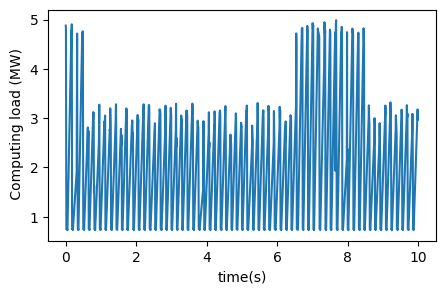

In [ ]:
TimeRecord=delta_t*np.arange(0,p_inj.shape[0])
fig = plt.figure(figsize=(5,3), dpi=100)

plt.plot(TimeRecord,-p_inj[:,6])
plt.xlabel('time(s)')
plt.ylabel(' Computing load (MW)')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/250805 data center/figure/Computing Load.png', bbox_inches='tight', dpi=600)


In [ ]:
p_inj.shape

(9999, 7)

### without control

s [-2.77555756e-17 -2.77555756e-17 -3.46944695e-17 -2.77555756e-17
 -2.77555756e-17 -3.46944695e-17 -3.46944695e-17 -3.46944695e-17
 -4.16333634e-17 -3.46944695e-17 -3.46944695e-17 -3.46944695e-17
 -2.77555756e-17]


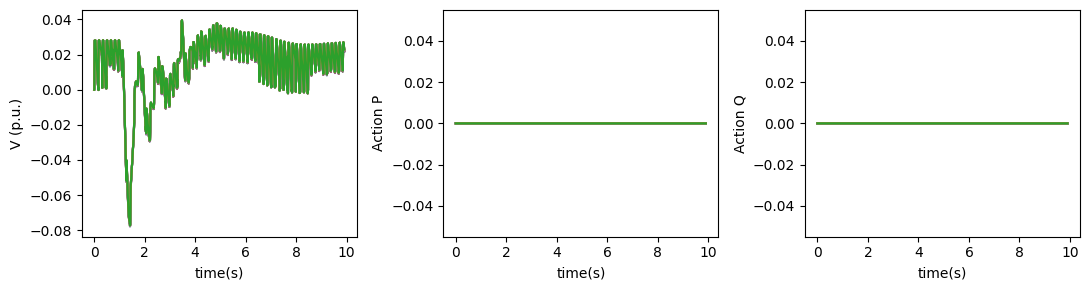

In [ ]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[]
Q_init_ratio = 0.7
P_init_ratio = 0.7
delta_t = 0.001
Q = 1*Q_ref
# 0*(Q_ref*np.random.uniform(1-Q_init_ratio ,1+Q_init_ratio ,(dim_action, 1))).T
# P = (P_ref*np.random.uniform(1-P_init_ratio ,1+P_init_ratio ,(dim_action, 1))).T
P = P_ref
linear_coffp = tf.math.minimum(modelLinear0.variables[0], K_bound_p)*0
linear_coffq = tf.math.minimum(modelLinear0.variables[1], K_bound_q)*0

s_concate=P@Matrix_R.T+Q@Matrix_X.T
init_state=s_concate.copy()
s=init_state.copy()
# SimulationLength=6000
# Record_u_Linear=[]
Record_up_Linear=[]
Record_uq_Linear=[]
Trajectory_Linear.append(s)
Record_Loss_Linear=[]
Loss_Linear=0
print('s',s)
record_v0 = np.diff(record_fault_trajectory[0,0,0,0:])
for i in range(SimulationLength):
    up=np.squeeze(Action_linear(s,linear_coffp))
    uq=np.squeeze(Action_linear(s,linear_coffq))
    next_s= s - uq@Matrix_X - up@Matrix_R + record_v0[i]+ 0.7*p_inj_diff[i]@Matrix_R
    s=next_s.copy()
    Trajectory_Linear.append(s.copy())
    Record_up_Linear.append(up.copy())
    Record_uq_Linear.append(uq.copy())

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
fig = plt.figure(figsize=(11,3), dpi=100)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,1)
plt.plot(TimeRecord,Trajectory_Linear)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,2)
plt.plot(TimeRecord,Record_up_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action P')

plt.subplot(1,3,3)
plt.plot(TimeRecord,Record_uq_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action Q')
fig.tight_layout()
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/250805 data center/figure/WoControl.png', bbox_inches='tight', dpi=600)


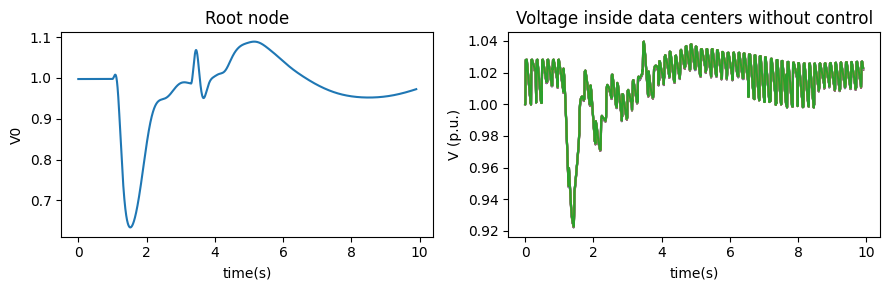

In [ ]:
fig = plt.figure(figsize=(9,3), dpi=100)

TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,2,2)
plt.plot(TimeRecord,Trajectory_Linear+1)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')
plt.title('Voltage inside data centers without control')
plt.subplot(1,2,1)
plt.plot(TimeRecord,record_fault_trajectory[3,0,3,0:SimulationLength+1])
plt.xlabel('time(s)')
plt.ylabel('V0')
plt.title('Root node')
fig.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/250805 data center/figure/WoControl.png', bbox_inches='tight', dpi=600)


# Training -q-diff

In [ ]:
class RNNModel(tf.keras.Model):
    def __init__(self, cell):
        super().__init__()
        self.rnn = tf.keras.layers.RNN(cell, return_sequences=True, stateful=True)

    def call(self, inputs, initial_state=None):
        return self.rnn(inputs, initial_state=initial_state)

In [ ]:
# RNN Cell to integrate state transition dynamics
class MinimalRNNCellLinear0(keras.layers.Layer):

    def __init__(self, units,action_units,internal_units,env,batchsize,K_boundq, K_boundp,**kwargs):
        self.units = units
        self.action_units = action_units
        self.state_size = units
        self.internal_units = internal_units
        self.batchsize=batchsize
        self.Matrix_X=tf.constant(env.Matrix_X,dtype=tf.float32)
        self.Matrix_R=tf.constant(env.Matrix_R,dtype=tf.float32)
        self.inv_Matrix_X = tf.constant(env.inv_Matrix_X,dtype=tf.float32)
        self.lambda_max = tf.constant(env.lambda_max,dtype=tf.float32)
        self.max_action=tf.constant(env.max_action,dtype=tf.float32)
        self.bound_slopq = tf.constant(K_boundq.reshape((1,-1)),dtype=tf.float32)
        self.bound_slopp = tf.constant(K_boundp.reshape((1,-1)),dtype=tf.float32)
        self.norm_q=1
        super(MinimalRNNCellLinear0, self).__init__(**kwargs)

    def build(self, input_shape):


        self.linear_Kq= self.add_weight(
            shape=(1,self.action_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0.1, maxval=0.5),
            trainable=True,
            constraint=tf.keras.constraints.NonNeg(),
            name='linear_Kq')
        self.built = True

    def call(self, inputs_concate, states):
        # stacked ReLU structure to represent control network
        prev_state = states[0]
        prev_state_x = prev_state[:,0:self.action_units]
        prev_state_q =  prev_state[:,self.action_units:2*self.action_units]
        inputs_p = inputs_concate[:,0:self.action_units]
        inputs_v0 = inputs_concate[:,self.action_units:self.action_units+1]


        linear_Kq_=tf.math.minimum(self.linear_Kq, self.bound_slopq )
        action_nonconstrain= K.sum(tf.linalg.diag(prev_state_x)*linear_Kq_,axis=2)
        action_q=self.max_action-K.relu(self.max_action-action_nonconstrain)+K.relu(-self.max_action-action_nonconstrain)
        new_state_x=prev_state_x-K.dot(action_q, tf.transpose(self.Matrix_X))+ K.dot(inputs_p, tf.transpose(self.Matrix_R)) + K.dot(inputs_v0, tf.ones((1,self.action_units)))
        new_state_q = prev_state_q - action_q

        next_state =  tf.concat([new_state_x, new_state_q], axis = 1)


        return [new_state_x,action_q, new_state_q], [next_state]




In [ ]:
p_inj_diff = np.diff(p_inj, axis=0)

In [ ]:
episodes =1000 # total number of iterations to update weights
action_units=dim_action
units=action_units*2 #dimension of each state
internal_units=20 # demension of the neural network for control policy

T=100  #Total period considered
Batch_num=500 # number of batch in each episodes
learning_rate_initial=0.01
decay_stage = 100
decay_rate = 0.9

cellLinear0 = MinimalRNNCellLinear0(units,action_units,internal_units,env,Batch_num,K_bound_q,K_bound_p)
modelLinear0 = RNNModel(cellLinear0)

Loss_record=[]
Pe_rnn_record=[]
global_step = tf.Variable(0, trainable=False)
decayed_lr =tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate_initial, decay_stage, decay_rate, staircase=True)
optimizer=tf.keras.optimizers.Adam(learning_rate=decayed_lr)

Length_pred_dataset = p_inj_diff.shape[0]-100
column1_idx = np.arange(0,dim_action)
PrintUpdate = 1
for i in range(0,episodes):
    initial_state_q = (1- np.random.uniform(-Q_init_ratio,Q_init_ratio,(Batch_num,action_units)))*(Q_ref.T)
    initial_state_p = (1- np.random.uniform(-P_init_ratio,P_init_ratio,(Batch_num,action_units)))*(P_ref.T)
    initial_state=initial_state_p@Matrix_R.T+initial_state_q@Matrix_X.T

    Input_config = np.zeros((Batch_num,T,dim_action+1))
    for j in range(Batch_num):
       #### time varying p
       t_init_Pm = np.random.randint(0, Length_pred_dataset-T-1)
       Input_config[j,:,:dim_action]=p_inj_diff[t_init_Pm:t_init_Pm+T,:]
       ###### v0
       rand_fault_idx = np.random.randint(0,np.shape(record_fault_trajectory)[0])
       rand_time_idx = np.random.randint(1050,1150)
       rand_bus_idx = np.random.randint(0,np.shape(record_fault_trajectory)[2])
       Input_config[j,:,dim_action] = record_fault_trajectory[rand_fault_idx,0,rand_bus_idx,rand_time_idx:rand_time_idx+T]


    with tf.GradientTape(persistent=True) as tape:
        [voltage,action_q,record_q]=modelLinear0(Input_config, np.hstack((initial_state, initial_state_q)))
        loss_voltage=K.sum(K.sum(K.abs(voltage)))/Batch_num/T/dim_action
        loss_action=0.01*(env.Penalty_action*K.sum(abs(record_q)))/Batch_num/T/dim_action
        loss=loss_voltage+loss_action
    grads = tape.gradient(loss, modelLinear0.variables)
    optimizer.apply_gradients(zip(grads, modelLinear0.variables))
    Loss_record.append(loss)



    if i % (PrintUpdate) == 0:
        print('episode',i, 'Loss',loss)
        print('         Loss_Voltage',loss_voltage, '  loss_action', loss_action)



episode 0 Loss tf.Tensor(14.981677, shape=(), dtype=float32)
         Loss_Voltage tf.Tensor(14.7773905, shape=(), dtype=float32)   loss_action tf.Tensor(0.20428626, shape=(), dtype=float32)
episode 1 Loss tf.Tensor(14.599428, shape=(), dtype=float32)
         Loss_Voltage tf.Tensor(14.393462, shape=(), dtype=float32)   loss_action tf.Tensor(0.20596634, shape=(), dtype=float32)
episode 2 Loss tf.Tensor(14.27889, shape=(), dtype=float32)
         Loss_Voltage tf.Tensor(14.070687, shape=(), dtype=float32)   loss_action tf.Tensor(0.20820199, shape=(), dtype=float32)
episode 3 Loss tf.Tensor(13.942223, shape=(), dtype=float32)
         Loss_Voltage tf.Tensor(13.732393, shape=(), dtype=float32)   loss_action tf.Tensor(0.20982955, shape=(), dtype=float32)
episode 4 Loss tf.Tensor(13.622835, shape=(), dtype=float32)
         Loss_Voltage tf.Tensor(13.411407, shape=(), dtype=float32)   loss_action tf.Tensor(0.21142785, shape=(), dtype=float32)
episode 5 Loss tf.Tensor(13.338716, shape=(), dtyp

In [ ]:
p_inj.shape

(999, 7)

In [ ]:
episodes =1000 # total number of iterations to update weights
action_units=dim_action
units=action_units*3 #dimension of each state
internal_units=20 # demension of the neural network for control policy

T=100  #Total period considered
Batch_num=500 # number of batch in each episodes
learning_rate_initial=0.01
decay_stage = 100
decay_rate = 0.9

cellLinear0 = MinimalRNNCellLinear0(units,action_units,internal_units,env,Batch_num,K_bound_q,K_bound_p)
modelLinear0 = RNNModel(cellLinear0)

Loss_record=[]
Pe_rnn_record=[]
global_step = tf.Variable(0, trainable=False)
decayed_lr =tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate_initial, decay_stage, decay_rate, staircase=True)
optimizer=tf.keras.optimizers.Adam(learning_rate=decayed_lr)



Text(0, 0.5, 'Loss')

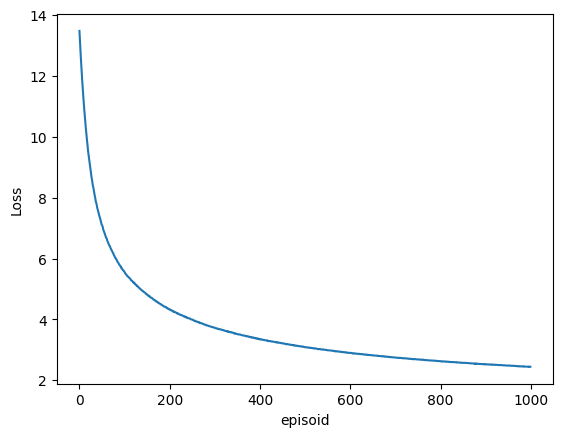

In [ ]:
plt.plot(Loss_record)
plt.xlabel('episoid')
plt.ylabel('Loss')
# plt.title('Non-Discounted Loss without penalty')

In [ ]:
modelLinear0.save_weights('/content/drive/MyDrive/Colab Notebooks/250805 data center/data/weights_Vulcan_K_250808_n8_q_t001.weights.h5')
# modelLinear0.load_weights('/content/drive/MyDrive/Colab Notebooks/250805 data center/data/weights_K_250808_t001.weights.h5')
# modelLinear0.load_weights('/content/drive/MyDrive/Colab Notebooks/250805 data center/data/weights_Vulcan_K_250808_n8_t001.weights.h5')


## Simulation and Comparisons

### With trained controller

s [-2.77555756e-17 -2.77555756e-17 -3.46944695e-17 -2.77555756e-17
 -2.77555756e-17 -3.46944695e-17 -3.46944695e-17 -3.46944695e-17
 -4.16333634e-17 -3.46944695e-17 -3.46944695e-17 -3.46944695e-17
 -2.77555756e-17]


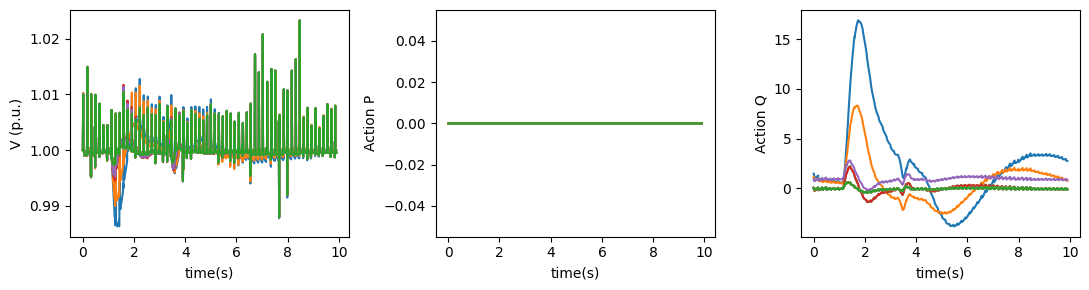

In [ ]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[]
# Q_init_ratio = 0.7
# P_init_ratio = 0.7
# delta_t = 0.001
Q = Q_ref
# # 0*(Q_ref*np.random.uniform(1-Q_init_ratio ,1+Q_init_ratio ,(dim_action, 1))).T
# # P = (P_ref*np.random.uniform(1-P_init_ratio ,1+P_init_ratio ,(dim_action, 1))).T
P = P_ref
linear_coffq = tf.math.minimum(modelLinear0.variables[0], K_bound_q)

s_concate=P@Matrix_R.T+Q@Matrix_X.T
init_state=s_concate.copy()
s=init_state.copy()
SimulationLength=10000-100
# Record_u_Linear=[]
Record_up_Linear=[]
Record_uq_Linear=[]
Record_uq_Linear.append(Q)
Trajectory_Linear.append(s)
Record_Loss_Linear=[]
Loss_Linear=0
print('s',s)
record_v0 = np.diff(record_fault_trajectory[3,0,3,0:])
for i in range(SimulationLength):
    uq=np.squeeze(Action_linear(s,linear_coffq))
    next_s= s - uq@Matrix_X + record_v0[i]+ p_inj_diff[i]@Matrix_R
    s=next_s.copy()
    Trajectory_Linear.append(s.copy())
    Record_uq_Linear.append(Record_uq_Linear[-1]-uq.copy())

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
fig = plt.figure(figsize=(11,3), dpi=100)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,1)
plt.plot(TimeRecord,Trajectory_Linear+1)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=delta_t*TimeRecord
Record_up_Linear = np.zeros((SimulationLength+1,dim_action))
plt.subplot(1,3,2)
plt.plot(TimeRecord,Record_up_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action P')

plt.subplot(1,3,3)
plt.plot(TimeRecord,Record_uq_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action Q')
fig.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/250805 data center/figure/exp_decentralized_F4_q.png', bbox_inches='tight', dpi=600)


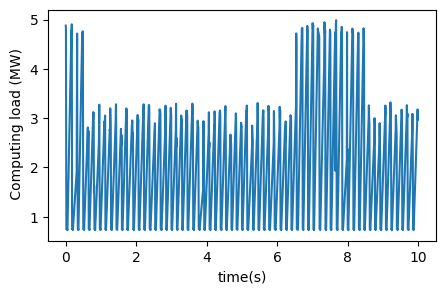

In [ ]:
TimeRecord=delta_t*np.arange(0,p_inj.shape[0])
fig = plt.figure(figsize=(5,3), dpi=100)

plt.plot(TimeRecord,-p_inj[:,6])
plt.xlabel('time(s)')
plt.ylabel(' Computing load (MW)')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/250805 data center/figure/Computing Load.png', bbox_inches='tight', dpi=600)


In [ ]:
p_inj.shape

(9999, 7)

### without control

s [-2.77555756e-17 -2.77555756e-17 -3.46944695e-17 -2.77555756e-17
 -2.77555756e-17 -3.46944695e-17 -3.46944695e-17 -3.46944695e-17
 -4.16333634e-17 -3.46944695e-17 -3.46944695e-17 -3.46944695e-17
 -2.77555756e-17]


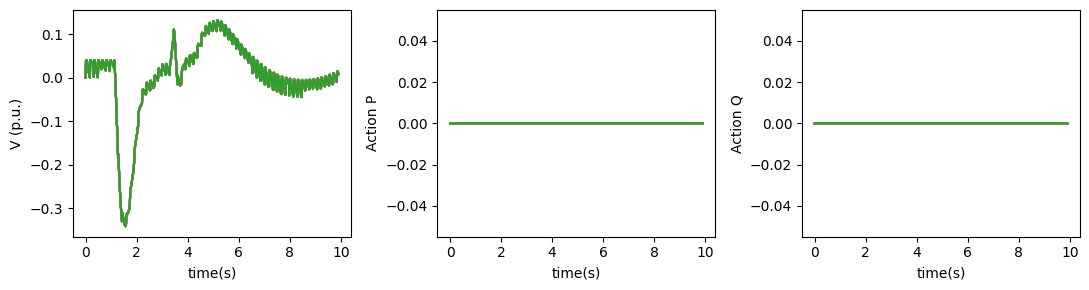

In [ ]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[]
Q_init_ratio = 0.7
P_init_ratio = 0.7
delta_t = 0.001
Q = 1*Q_ref
# 0*(Q_ref*np.random.uniform(1-Q_init_ratio ,1+Q_init_ratio ,(dim_action, 1))).T
# P = (P_ref*np.random.uniform(1-P_init_ratio ,1+P_init_ratio ,(dim_action, 1))).T
P = P_ref
linear_coffp = tf.math.minimum(modelLinear0.variables[0], K_bound_p)*0
linear_coffq = tf.math.minimum(modelLinear0.variables[0], K_bound_q)*0

s_concate=P@Matrix_R.T+Q@Matrix_X.T
init_state=s_concate.copy()
s=init_state.copy()
# SimulationLength=6000
# Record_u_Linear=[]
Record_up_Linear=[]
Record_uq_Linear=[]
Trajectory_Linear.append(s)
Record_Loss_Linear=[]
Loss_Linear=0
print('s',s)
# record_v0 = np.diff(record_fault_trajectory[0,0,0,0:])
for i in range(SimulationLength):
    up=np.squeeze(Action_linear(s,linear_coffp))
    uq=np.squeeze(Action_linear(s,linear_coffq))
    next_s= s - uq@Matrix_X - up@Matrix_R + record_v0[i]+ p_inj_diff[i]@Matrix_R
    s=next_s.copy()
    Trajectory_Linear.append(s.copy())
    Record_up_Linear.append(up.copy())
    Record_uq_Linear.append(uq.copy())

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
fig = plt.figure(figsize=(11,3), dpi=100)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,1)
plt.plot(TimeRecord,Trajectory_Linear)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,2)
plt.plot(TimeRecord,Record_up_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action P')

plt.subplot(1,3,3)
plt.plot(TimeRecord,Record_uq_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action Q')
fig.tight_layout()
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/250805 data center/figure/WoControl.png', bbox_inches='tight', dpi=600)


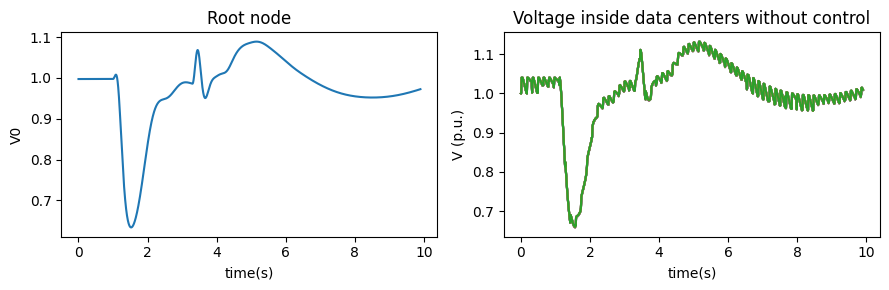

In [ ]:
fig = plt.figure(figsize=(9,3), dpi=100)

TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,2,2)
plt.plot(TimeRecord,Trajectory_Linear+1)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')
plt.title('Voltage inside data centers without control')
plt.subplot(1,2,1)
plt.plot(TimeRecord,record_fault_trajectory[3,0,3,0:SimulationLength+1])
plt.xlabel('time(s)')
plt.ylabel('V0')
plt.title('Root node')
fig.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/250805 data center/figure/exp_no_control_F4.png', bbox_inches='tight', dpi=600)
